In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from PIL import Image
import os
import random
from collections import defaultdict
from sam.sam import SAM as SAM_Wrapper
from sam.example.utility.bypass_bn import enable_running_stats, disable_running_stats
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Make CUDA ops deterministic where possible
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Generator seeded for deterministic splits
_gen = torch.Generator()
_gen.manual_seed(SEED)

# Ensure random_split uses the seeded generator by default
_orig_random_split = random_split
def random_split(dataset, lengths, generator=None):
    return _orig_random_split(dataset, lengths, generator=generator if generator is not None else _gen)

# Loading Dataset (PACS)

In [3]:
class Identity(nn.Module):
    """An identity layer"""
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    
class ResNet(torch.nn.Module):
    """ResNet with the softmax chopped off and the batchnorm frozen"""
    def __init__(self, input_shape, hparams):
        super(ResNet, self).__init__()
        if hparams['resnet18']:
            self.network = torchvision.models.resnet18(pretrained=True)
            self.n_outputs = 512
        else:
            self.network = torchvision.models.resnet50(pretrained=True)
            self.n_outputs = 2048

        # self.network = remove_batch_norm_from_resnet(self.network)

        # adapt number of channels
        nc = input_shape[0]
        if nc != 3:
            tmp = self.network.conv1.weight.data.clone()

            self.network.conv1 = nn.Conv2d(
                nc, 64, kernel_size=(7, 7),
                stride=(2, 2), padding=(3, 3), bias=False)

            for i in range(nc):
                self.network.conv1.weight.data[:, i, :, :] = tmp[:, i % 3, :, :]

        # save memory
        del self.network.fc
        self.network.fc = Identity()

        if hparams["freeze_bn"]:
            self.freeze_bn()
        self.hparams = hparams
        self.dropout = nn.Dropout(hparams['resnet_dropout'])
        self.activation = nn.Identity() # for URM; does not affect other algorithms

    def forward(self, x):
        """Encode x into a feature vector of size n_outputs."""
        return self.activation(self.dropout(self.network(x)))

    def train(self, mode=True):
        """
        Override the default train() to freeze the BN parameters
        """
        super().train(mode)
        if self.hparams["freeze_bn"]:
            self.freeze_bn()

    def freeze_bn(self):
        for m in self.network.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()



def Featurizer(input_shape, hparams):
    """Auto-select an appropriate featurizer for the given input shape."""
    if input_shape[1:3] == (224, 224):
        return ResNet(input_shape, hparams)
    else:
        raise NotImplementedError


def Classifier(in_features, out_features, is_nonlinear=False):
    if is_nonlinear:
        return torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features // 2, in_features // 4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features // 4, out_features))
    else:
        return torch.nn.Linear(in_features, out_features)

class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain generalization algorithm.
    Subclasses should implement the following:
    - update()
    - predict()
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(Algorithm, self).__init__()
        self.hparams = hparams

    def update(self, minibatches, unlabeled=None):
        """
        Perform one update step, given a list of (x, y) tuples for all
        environments.

        Admits an optional list of unlabeled minibatches from the test domains,
        when task is domain_adaptation.
        """
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError

In [4]:
MODEL_DIR = '/home/csalt/Haider/ATML/ATML-PA 2/Task2_Models'

In [5]:
DIR_PHOTO = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/photo'
DIR_ART = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/art_painting'
DIR_CARTOON = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/cartoon'
DIR_SKETCH = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH)

print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [6]:
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # PACS has 7 classes
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Collect image paths and labels
        for domain in domains:
            domain_dir = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_dir):
                if class_name in self.classes:
                    class_dir = os.path.join(domain_dir, class_name)
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith('.jpg') or img_name.endswith('.png'):
                            self.samples.append((
                                os.path.join(class_dir, img_name),
                                self.class_to_idx[class_name],
                                domain
                            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, domain = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, domain

In [7]:
TRAIN_DOMAINS = ['photo', 'art_painting', 'cartoon']
TEST_DOMAINS = ['sketch']

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pacs_train = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TRAIN_DOMAINS,
    transform=transform
)
pacs_test = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TEST_DOMAINS,
    transform=transform
)

In [8]:
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ALTERNATIVELY DO NOT CREATE A VALIDATION SPLIT
pacs_train_loader = DataLoader(pacs_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
pacs_test_loader = DataLoader(pacs_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training on {len(pacs_train)} images from domains: {', '.join(TRAIN_DOMAINS)}")
print(f"Testing on {len(pacs_test)} images from domain: {', '.join(TEST_DOMAINS)}")

Training on 6062 images from domains: photo, art_painting, cartoon
Testing on 3929 images from domain: sketch


In [9]:
pacs_source_loader = DataLoader(pacs_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

pacs_photo = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['photo'],transform=transform)
pacs_photo_loader = DataLoader(pacs_photo, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_art_painting = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['art_painting'],transform=transform)
pacs_art_painting_loader = DataLoader(pacs_art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_cartoon = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['cartoon'],transform=transform)
pacs_cartoon_loader = DataLoader(pacs_cartoon, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Helper Functions

In [23]:
def compute_accuracy(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model.predict(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

# 1) ERM Baseline

In [10]:
class ERM(Algorithm):
    """
    Empirical Risk Minimization (ERM)
    """

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(ERM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.featurizer = Featurizer(input_shape, self.hparams)
        self.classifier = Classifier(
            self.featurizer.n_outputs,
            num_classes,
            self.hparams['nonlinear_classifier'])
        self.network = nn.Sequential(self.featurizer, self.classifier)
        
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams['weight_decay']
        )

    def update(self, minibatches, unlabeled=None):
        all_x = torch.cat([x for x, y in minibatches])
        all_y = torch.cat([y for x, y in minibatches])
        loss = F.cross_entropy(self.predict(all_x), all_y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item()}

    def predict(self, x):
        return self.network(x)

In [25]:
ERM_PATH = '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/erm_training'
ERM_MODELS = ["_step0", "_step1000", "_step2000", "_step3000", "_step4000", "_step5000", "",]
ERM_NAMES = ["Step 0", "Step 1000", "Step 2000", "Step 3000", "Step 4000", "Step 5000", "Final Model"]

for model_suffix, model_name in zip(ERM_MODELS, ERM_NAMES):
    checkpoint_path = os.path.join(ERM_PATH, f'model{model_suffix}.pkl')
    checkpoint = torch.load(checkpoint_path)
    ERM_Model = ERM(input_shape=checkpoint['model_input_shape'],
                    num_classes=checkpoint['model_num_classes'],
                    num_domains=checkpoint['model_num_domains'],
                    hparams=checkpoint['model_hparams'])
    ERM_Model.load_state_dict(checkpoint["model_dict"])
    ERM_Model.to(DEVICE)
    
    print(f"Loading ERM model: {model_name}")
    print("\tTarget Domain Evaluation:")
    sketch_accuracy = compute_accuracy(ERM_Model, pacs_test_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
    
    print("\tSource Domain Evaluation:")
    source_accuracy_erm = compute_accuracy(ERM_Model, pacs_source_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_erm:.2f}%")

    source_photo_accuracy_erm = compute_accuracy(ERM_Model, pacs_photo_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_erm:.2f}%")

    source_art_painting_accuracy_erm = compute_accuracy(ERM_Model, pacs_art_painting_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_erm:.2f}%")

    source_cartoon_accuracy_erm = compute_accuracy(ERM_Model, pacs_cartoon_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_erm:.2f}%")

    domain_accuracies = [source_photo_accuracy_erm, source_art_painting_accuracy_erm, source_cartoon_accuracy_erm]
    worst_group_acc_erm = min(domain_accuracies)
    avg_source_acc_erm = np.mean(domain_accuracies)
    print(f"\t\tWorst-group accuracy (source domains): {worst_group_acc_erm:.2f}%")
    print(f"\t\tAverage accuracy (source domains): {avg_source_acc_erm:.2f}%")
        

Loading ERM model: Step 0
	Target Domain Evaluation:
		ResNet-50 Accuracy on PACS Sketch Domain: 12.70%
	Source Domain Evaluation:
		ResNet-50 Accuracy on PACS Source Domains: 26.43%
		ResNet-50 Accuracy on PACS Art Painting Domain: 31.62%
		ResNet-50 Accuracy on PACS Art Domain: 21.88%
		ResNet-50 Accuracy on PACS Cartoon Domain: 26.71%
		Worst-group accuracy (source domains): 21.88%
		Average accuracy (source domains): 26.73%
Loading ERM model: Step 1000
	Target Domain Evaluation:
		ResNet-50 Accuracy on PACS Sketch Domain: 60.47%
	Source Domain Evaluation:
		ResNet-50 Accuracy on PACS Source Domains: 99.11%
		ResNet-50 Accuracy on PACS Art Painting Domain: 99.28%
		ResNet-50 Accuracy on PACS Art Domain: 98.63%
		ResNet-50 Accuracy on PACS Cartoon Domain: 99.40%
		Worst-group accuracy (source domains): 98.63%
		Average accuracy (source domains): 99.11%
Loading ERM model: Step 2000
	Target Domain Evaluation:
		ResNet-50 Accuracy on PACS Sketch Domain: 72.18%
	Source Domain Evaluation:

# 2) IRM

In [11]:
class IRM(ERM):
    """Invariant Risk Minimization"""

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(IRM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.register_buffer('update_count', torch.tensor([0]))

    @staticmethod
    def _irm_penalty(logits, y):
        device = "cuda" if logits[0][0].is_cuda else "cpu"
        scale = torch.tensor(1.).to(device).requires_grad_()
        loss_1 = F.cross_entropy(logits[::2] * scale, y[::2])
        loss_2 = F.cross_entropy(logits[1::2] * scale, y[1::2])
        grad_1 = autograd.grad(loss_1, [scale], create_graph=True)[0]
        grad_2 = autograd.grad(loss_2, [scale], create_graph=True)[0]
        result = torch.sum(grad_1 * grad_2)
        return result

    def update(self, minibatches, unlabeled=None):
        device = "cuda" if minibatches[0][0].is_cuda else "cpu"
        penalty_weight = (self.hparams['irm_lambda'] if self.update_count
                          >= self.hparams['irm_penalty_anneal_iters'] else
                          1.0)
        nll = 0.
        penalty = 0.

        all_x = torch.cat([x for x, y in minibatches])
        all_logits = self.network(all_x)
        all_logits_idx = 0
        for i, (x, y) in enumerate(minibatches):
            logits = all_logits[all_logits_idx:all_logits_idx + x.shape[0]]
            all_logits_idx += x.shape[0]
            nll += F.cross_entropy(logits, y)
            penalty += self._irm_penalty(logits, y)
        nll /= len(minibatches)
        penalty /= len(minibatches)
        loss = nll + (penalty_weight * penalty)

        if self.update_count == self.hparams['irm_penalty_anneal_iters']:
            # Reset Adam, because it doesn't like the sharp jump in gradient
            # magnitudes that happens at this step.
            self.optimizer = torch.optim.Adam(
                self.network.parameters(),
                lr=self.hparams["lr"],
                weight_decay=self.hparams['weight_decay'])

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_count += 1
        return {'loss': loss.item(), 'nll': nll.item(),
            'penalty': penalty.item()}


In [29]:
IRM_PENALTIES = [0.1, 10, 100, 10000]
IRM_MODELS = ["_step0", "_step1000", "_step2000", "_step3000", "_step4000", "_step5000", "",]
IRM_NAMES = ["Step 0", "Step 1000", "Step 2000", "Step 3000", "Step 4000", "Step 5000", "Final Model"]

for penalty in IRM_PENALTIES:
    print(f"Evaluating IRM models with penalty: {penalty}")
    
    for model_suffix, model_name in zip(IRM_MODELS, IRM_NAMES):
        print(f"Loading IRM model: {model_name}")
        checkpoint_path = f"/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_{penalty}_penalty/model{model_suffix}.pkl"
        checkpoint = torch.load(checkpoint_path)
        IRM_Model = IRM(input_shape=checkpoint['model_input_shape'],
                        num_classes=checkpoint['model_num_classes'],
                        num_domains=checkpoint['model_num_domains'],
                        hparams=checkpoint['model_hparams'])
        IRM_Model.load_state_dict(checkpoint["model_dict"])
        IRM_Model.to(DEVICE)
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy(IRM_Model, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_IRM = compute_accuracy(IRM_Model, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_IRM:.2f}%")

        source_photo_accuracy_IRM = compute_accuracy(IRM_Model, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_IRM:.2f}%")

        source_art_painting_accuracy_IRM = compute_accuracy(IRM_Model, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_IRM:.2f}%")

        source_cartoon_accuracy_IRM = compute_accuracy(IRM_Model, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_IRM:.2f}%")

        domain_accuracies = [source_photo_accuracy_IRM, source_art_painting_accuracy_IRM, source_cartoon_accuracy_IRM]
        worst_group_acc_IRM = min(domain_accuracies)
        avg_source_acc_IRM = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_IRM:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_IRM:.2f}%")
            

Evaluating IRM models with penalty: 0.1
Loading IRM model: Step 0
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 8.53%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 25.50%
	ResNet-50 Accuracy on PACS Art Painting Domain: 31.08%
	ResNet-50 Accuracy on PACS Art Domain: 21.73%
	ResNet-50 Accuracy on PACS Cartoon Domain: 24.83%

Worst-group accuracy (source domains): 21.73%
Average accuracy (source domains): 25.88%
Loading IRM model: Step 1000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 73.99%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.18%
	ResNet-50 Accuracy on PACS Art Painting Domain: 99.46%
	ResNet-50 Accuracy on PACS Art Domain: 98.78%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.32%

Worst-group accuracy (source domains): 98.78%
Average accuracy (source domains): 99.19%
Loading IRM model: Step 2000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 73.89%
Source Do

# 3) Group DRO

In [34]:
class GroupDRO(ERM):
    """
    Robust ERM minimizes the error at the worst minibatch
    Algorithm 1 from [https://arxiv.org/pdf/1911.08731.pdf]
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(GroupDRO, self).__init__(input_shape, num_classes, num_domains,
                                        hparams)
        self.register_buffer("q", torch.Tensor())
        
        self.register_buffer("q", torch.ones(num_domains))

    def update(self, minibatches, unlabeled=None):
        device = "cuda" if minibatches[0][0].is_cuda else "cpu"

        if not len(self.q):
            self.q = torch.ones(len(minibatches)).to(device)

        losses = torch.zeros(len(minibatches)).to(device)

        for m in range(len(minibatches)):
            x, y = minibatches[m]
            losses[m] = F.cross_entropy(self.predict(x), y)
            self.q[m] *= (self.hparams["groupdro_eta"] * losses[m].data).exp()

        self.q /= self.q.sum()
        loss = torch.dot(losses, self.q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item(), 'weights': self.q.data.cpu().numpy().tolist()}

In [35]:
GDRO_ETA = [0.001, 0.01, 0.1]
GDRO_MODELS = ["_step0", "_step500", "_step1000", "_step1500", "_step2000", "_step2500", "_step3000", "_step3500", "_step4000", "_step4500", "_step5000", ""]
GDRO_NAMES = ["Step 0", "Step 500", "Step 1000", "Step 1500", "Step 2000", "Step 2500", "Step 3000", "Step 3500", "Step 4000", "Step 4500", "Step 5000", "Final Model"]

for eta in GDRO_ETA:
    print(f"Evaluating GDRO models with eta: {eta}")
    
    for model_suffix, model_name in zip(GDRO_MODELS, GDRO_NAMES):
        print(f"Loading GDRO model: {model_name}")
        checkpoint_path = f"/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_{eta}_eta/model{model_suffix}.pkl"
        checkpoint = torch.load(checkpoint_path)
        GDRO_Model = GroupDRO(input_shape=checkpoint['model_input_shape'],
                        num_classes=checkpoint['model_num_classes'],
                        num_domains=checkpoint['model_num_domains'],
                        hparams=checkpoint['model_hparams'])
        GDRO_Model.load_state_dict(checkpoint["model_dict"])
        GDRO_Model.to(DEVICE)
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy(GDRO_Model, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_GDRO = compute_accuracy(GDRO_Model, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_GDRO:.2f}%")

        source_photo_accuracy_GDRO = compute_accuracy(GDRO_Model, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_GDRO:.2f}%")

        source_art_painting_accuracy_GDRO = compute_accuracy(GDRO_Model, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_GDRO:.2f}%")

        source_cartoon_accuracy_GDRO = compute_accuracy(GDRO_Model, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_GDRO:.2f}%")

        domain_accuracies = [source_photo_accuracy_GDRO, source_art_painting_accuracy_GDRO, source_cartoon_accuracy_GDRO]
        worst_group_acc_GDRO = min(domain_accuracies)
        avg_source_acc_GDRO = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_GDRO:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_GDRO:.2f}%")
            

Evaluating GDRO models with eta: 0.001
Loading GDRO model: Step 0
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 15.60%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 26.15%
	ResNet-50 Accuracy on PACS Art Painting Domain: 32.28%
	ResNet-50 Accuracy on PACS Art Domain: 20.17%
	ResNet-50 Accuracy on PACS Cartoon Domain: 27.01%

Worst-group accuracy (source domains): 20.17%
Average accuracy (source domains): 26.48%
Loading GDRO model: Step 500
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 46.83%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 98.55%
	ResNet-50 Accuracy on PACS Art Painting Domain: 99.16%
	ResNet-50 Accuracy on PACS Art Domain: 97.56%
	ResNet-50 Accuracy on PACS Cartoon Domain: 98.98%

Worst-group accuracy (source domains): 97.56%
Average accuracy (source domains): 98.57%
Loading GDRO model: Step 1000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 64.85%
Source 

# 4) SAM

In [32]:
class SAM(Algorithm):
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(SAM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.featurizer = Featurizer(input_shape, self.hparams)
        self.classifier = Classifier(
            self.featurizer.n_outputs,
            num_classes,
            self.hparams['nonlinear_classifier'])

        self.network = nn.Sequential(self.featurizer, self.classifier)
        self.base_optimizer = torch.optim.SGD
        self.optimizer = SAM_Wrapper(self.network.parameters(), self.base_optimizer, rho=self.hparams["rho"], \
            adaptive=False, lr=self.hparams["lr"], momentum=0.9, weight_decay=self.hparams['weight_decay'])

    def update(self, minibatches, unlabeled=None):
        enable_running_stats(self.network)
        all_x = torch.cat([x for x, y in minibatches])
        all_y = torch.cat([y for x, y in minibatches])
        loss = F.cross_entropy(self.predict(all_x), all_y)
        loss.backward()
        self.optimizer.first_step(zero_grad=True)

        disable_running_stats(self.network)
        F.cross_entropy(self.predict(all_x), all_y).backward()
        self.optimizer.second_step(zero_grad=True)

        return {'loss': loss.item()}

    def predict(self, x):
        return self.network(x)

In [33]:
SAM_RHOS = [0.01, 0.05, 0.1]
SAM_MODELS = ["_step0", "_step1000", "_step2000", "_step3000", "_step4000", "_step5000", "",]
SAM_NAMES = ["Step 0", "Step 1000", "Step 2000", "Step 3000", "Step 4000", "Step 5000", "Final Model"]

for rhos in SAM_RHOS:
    print(f"Evaluating SAM models with rho: {rhos}")
    
    for model_suffix, model_name in zip(SAM_MODELS, SAM_NAMES):
        print(f"Loading SAM model: {model_name}")
        checkpoint_path = f"/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_{rhos}_rho/model{model_suffix}.pkl"
        checkpoint = torch.load(checkpoint_path)
        SAM_Model = SAM(input_shape=checkpoint['model_input_shape'],
                        num_classes=checkpoint['model_num_classes'],
                        num_domains=checkpoint['model_num_domains'],
                        hparams=checkpoint['model_hparams'])
        SAM_Model.load_state_dict(checkpoint["model_dict"])
        SAM_Model.to(DEVICE)
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy(SAM_Model, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_SAM = compute_accuracy(SAM_Model, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_SAM:.2f}%")

        source_photo_accuracy_SAM = compute_accuracy(SAM_Model, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_SAM:.2f}%")

        source_art_painting_accuracy_SAM = compute_accuracy(SAM_Model, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_SAM:.2f}%")

        source_cartoon_accuracy_SAM = compute_accuracy(SAM_Model, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_SAM:.2f}%")

        domain_accuracies = [source_photo_accuracy_SAM, source_art_painting_accuracy_SAM, source_cartoon_accuracy_SAM]
        worst_group_acc_SAM = min(domain_accuracies)
        avg_source_acc_SAM = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_SAM:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_SAM:.2f}%")
            

Evaluating SAM models with rho: 0.01
Loading SAM model: Step 0
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 6.74%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 10.41%
	ResNet-50 Accuracy on PACS Art Painting Domain: 6.23%
	ResNet-50 Accuracy on PACS Art Domain: 11.28%
	ResNet-50 Accuracy on PACS Cartoon Domain: 12.63%

Worst-group accuracy (source domains): 6.23%
Average accuracy (source domains): 10.04%
Loading SAM model: Step 1000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 48.15%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 97.77%
	ResNet-50 Accuracy on PACS Art Painting Domain: 99.64%
	ResNet-50 Accuracy on PACS Art Domain: 97.71%
	ResNet-50 Accuracy on PACS Cartoon Domain: 96.50%

Worst-group accuracy (source domains): 96.50%
Average accuracy (source domains): 97.95%
Loading SAM model: Step 2000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 53.17%
Source Domain 

# Manual Training

In [14]:
def compute_accuracy_manual(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

In [11]:
SAM_RHOS = ["0_01", "0_05", "0_1"]
SAM_MODELS = ["best_",""]
SAM_NAMES = ["Best Model", "Final Model"]

sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)


for rhos in SAM_RHOS:
    print(f"Evaluating SAM models with rho: {rhos}")
    
    for model_suffix, model_name in zip(SAM_MODELS, SAM_NAMES):
        print(f"Loading SAM model: {model_name}")
        sam_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'{model_suffix}sam_resnet_{rhos}.pth')))
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy_manual(sam_resnet_pacs, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_SAM:.2f}%")

        source_photo_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_SAM:.2f}%")

        source_art_painting_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_SAM:.2f}%")

        source_cartoon_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_SAM:.2f}%")

        domain_accuracies = [source_photo_accuracy_SAM, source_art_painting_accuracy_SAM, source_cartoon_accuracy_SAM]
        worst_group_acc_SAM = min(domain_accuracies)
        avg_source_acc_SAM = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_SAM:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_SAM:.2f}%")

Evaluating SAM models with rho: 0_01
Loading SAM model: Best Model
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 63.45%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.77%
	ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
	ResNet-50 Accuracy on PACS Art Domain: 99.80%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.57%

Worst-group accuracy (source domains): 99.57%
Average accuracy (source domains): 99.79%
Loading SAM model: Final Model
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 64.37%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.70%
	ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
	ResNet-50 Accuracy on PACS Art Domain: 99.71%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.49%

Worst-group accuracy (source domains): 99.49%
Average accuracy (source domains): 99.73%
Evaluating SAM models with rho: 0_05
Loading SAM model: Best Model
Target Domain Evaluation:
	ResNet-50 Accu

Different Seed

In [15]:
SAM_RHOS = ["0_01", "0_05", "0_1"]
SAM_MODELS = ["best_",""]
SAM_NAMES = ["Best Model", "Final Model"]

sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)


for rhos in SAM_RHOS:
    print(f"Evaluating SAM models with rho: {rhos}")
    
    for model_suffix, model_name in zip(SAM_MODELS, SAM_NAMES):
        print(f"Loading SAM model: {model_name}")
        sam_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'{model_suffix}sam_resnet_{rhos}.pth')))
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy_manual(sam_resnet_pacs, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_SAM:.2f}%")

        source_photo_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_SAM:.2f}%")

        source_art_painting_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_SAM:.2f}%")

        source_cartoon_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_SAM:.2f}%")

        domain_accuracies = [source_photo_accuracy_SAM, source_art_painting_accuracy_SAM, source_cartoon_accuracy_SAM]
        worst_group_acc_SAM = min(domain_accuracies)
        avg_source_acc_SAM = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_SAM:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_SAM:.2f}%")

Evaluating SAM models with rho: 0_01
Loading SAM model: Best Model
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 66.91%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.75%
	ResNet-50 Accuracy on PACS Art Painting Domain: 99.94%
	ResNet-50 Accuracy on PACS Art Domain: 99.80%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.57%

Worst-group accuracy (source domains): 99.57%
Average accuracy (source domains): 99.77%
Loading SAM model: Final Model
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 65.51%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.74%
	ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
	ResNet-50 Accuracy on PACS Art Domain: 99.80%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.49%

Worst-group accuracy (source domains): 99.49%
Average accuracy (source domains): 99.76%
Evaluating SAM models with rho: 0_05
Loading SAM model: Best Model
Target Domain Evaluation:
	ResNet-50 Accur


COMPARING ALL ALGORITHMS


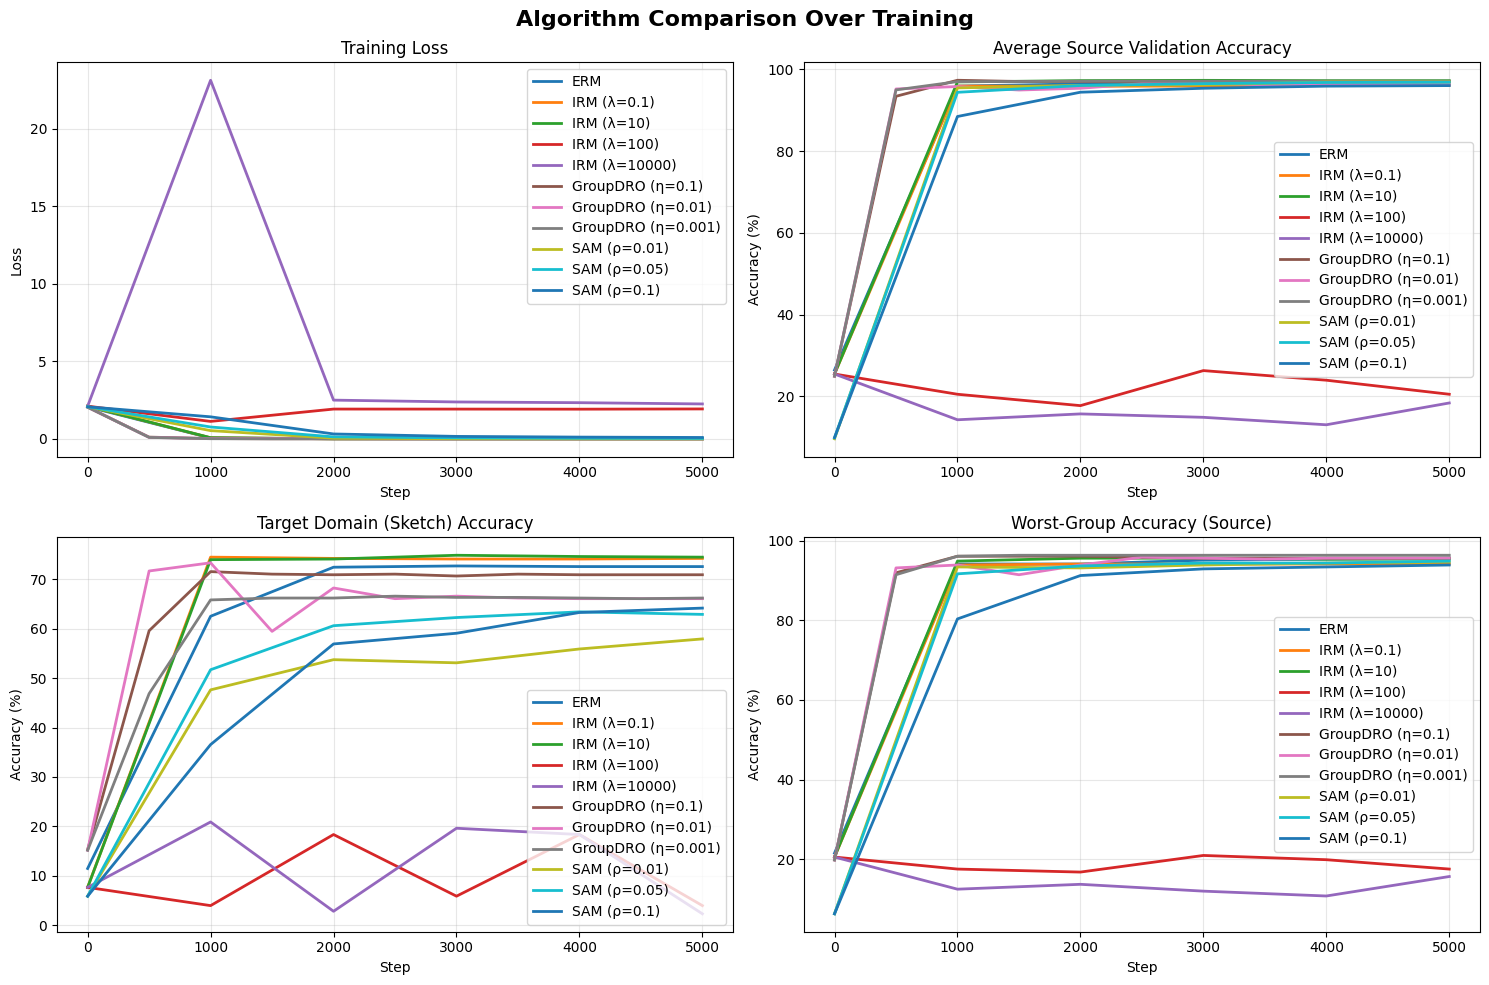


BEST CHECKPOINT SUMMARY
         Algorithm  Best Step Avg Source Val (%) Target Sketch (%) Worst Group (%) Photo (%) Art (%) Cartoon (%)
               ERM       5000              97.01             72.61           95.60     95.60   97.22       98.20
       IRM (λ=0.1)       4000              96.13             74.14           94.13     94.13   96.37       97.90
        IRM (λ=10)       3000              97.32             74.90           95.60     95.60   97.86       98.50
       IRM (λ=100)       3000              26.28              5.86           20.94     23.47   20.94       34.43
     IRM (λ=10000)          0              25.44              7.64           20.54     20.54   24.36       31.44
  GroupDRO (η=0.1)       1000              97.34             71.59           96.09     96.09   97.44       98.50
 GroupDRO (η=0.01)       2500              96.51             66.11           95.84     95.84   96.37       97.31
GroupDRO (η=0.001)       2000              97.12             66.24     

In [12]:
def load_results_jsonl(filepath):
    """Load results from a JSONL file into a pandas DataFrame."""
    results = []
    with open(filepath, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    return pd.DataFrame(results)

def plot_training_metrics(df, model_name, save_path=None):
    """Plot training metrics over time."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} Training Metrics', fontsize=16, fontweight='bold')
    
    # Plot 1: Loss over time
    axes[0, 0].plot(df['step'], df['loss'], 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Source domain accuracies
    axes[0, 1].plot(df['step'], df['env0_out_acc'] * 100, label='Photo', linewidth=2)
    axes[0, 1].plot(df['step'], df['env1_out_acc'] * 100, label='Art Painting', linewidth=2)
    axes[0, 1].plot(df['step'], df['env2_out_acc'] * 100, label='Cartoon', linewidth=2)
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Source Domain Validation Accuracies')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Target domain accuracy
    axes[1, 0].plot(df['step'], df['env3_out_acc'] * 100, 'r-', linewidth=2)
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Target Domain (Sketch) Accuracy')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Average source accuracy and worst-group accuracy
    df['avg_source_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
    df['worst_group_acc'] = df[['env0_out_acc', 'env1_out_acc', 'env2_out_acc']].min(axis=1)
    
    axes[1, 1].plot(df['step'], df['avg_source_acc'] * 100, label='Avg Source', linewidth=2)
    axes[1, 1].plot(df['step'], df['worst_group_acc'] * 100, label='Worst Group', linewidth=2)
    axes[1, 1].plot(df['step'], df['env3_out_acc'] * 100, label='Target (Sketch)', linewidth=2)
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Aggregated Metrics')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def get_best_checkpoint_info(df):
    """Get information about the best checkpoint based on average source validation accuracy."""
    df['avg_source_val_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
    best_idx = df['avg_source_val_acc'].idxmax()
    best_row = df.iloc[best_idx]
    
    return {
        'step': int(best_row['step']),
        'epoch': best_row['epoch'],
        'avg_source_val_acc': best_row['avg_source_val_acc'] * 100,
        'target_acc': best_row['env3_out_acc'] * 100,
        'photo_acc': best_row['env0_out_acc'] * 100,
        'art_acc': best_row['env1_out_acc'] * 100,
        'cartoon_acc': best_row['env2_out_acc'] * 100,
        'worst_group_acc': min(best_row['env0_out_acc'], best_row['env1_out_acc'], best_row['env2_out_acc']) * 100,
        'loss': best_row['loss']
    }

def compare_algorithms_over_time(results_dict):
    """Compare multiple algorithms' performance over training."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Algorithm Comparison Over Training', fontsize=16, fontweight='bold')
    
    for algo_name, df in results_dict.items():
        df['avg_source_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
        df['worst_group_acc'] = df[['env0_out_acc', 'env1_out_acc', 'env2_out_acc']].min(axis=1)
        
        # Plot loss
        axes[0, 0].plot(df['step'], df['loss'], label=algo_name, linewidth=2)
        
        # Plot average source accuracy
        axes[0, 1].plot(df['step'], df['avg_source_acc'] * 100, label=algo_name, linewidth=2)
        
        # Plot target accuracy
        axes[1, 0].plot(df['step'], df['env3_out_acc'] * 100, label=algo_name, linewidth=2)
        
        # Plot worst-group accuracy
        axes[1, 1].plot(df['step'], df['worst_group_acc'] * 100, label=algo_name, linewidth=2)
    
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Average Source Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Target Domain (Sketch) Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Worst-Group Accuracy (Source)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
# Compare multiple algorithms
print("\n" + "="*80)
print("COMPARING ALL ALGORITHMS")
print("="*80)

results_dict = {
    'ERM': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/erm_training/results.jsonl'),
    'IRM (λ=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_0.1_penalty/results.jsonl'),
    'IRM (λ=10)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10_penalty/results.jsonl'),
    'IRM (λ=100)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_100_penalty/results.jsonl'),
    'IRM (λ=10000)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10000_penalty/results.jsonl'),
    'GroupDRO (η=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.1_eta/results.jsonl'),
    'GroupDRO (η=0.01)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.01_eta/results.jsonl'),
    'GroupDRO (η=0.001)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.001_eta/results.jsonl'),
    'SAM (ρ=0.01)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.01_rho/results.jsonl'),
    'SAM (ρ=0.05)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.05_rho/results.jsonl'),
    'SAM (ρ=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.1_rho/results.jsonl')
}

compare_algorithms_over_time(results_dict)

# Create summary table of best checkpoints
print("\n" + "="*80)
print("BEST CHECKPOINT SUMMARY")
print("="*80)

summary_data = []
for algo_name, df in results_dict.items():
    best_info = get_best_checkpoint_info(df)
    summary_data.append({
        'Algorithm': algo_name,
        'Best Step': best_info['step'],
        'Avg Source Val (%)': f"{best_info['avg_source_val_acc']:.2f}",
        'Target Sketch (%)': f"{best_info['target_acc']:.2f}",
        'Worst Group (%)': f"{best_info['worst_group_acc']:.2f}",
        'Photo (%)': f"{best_info['photo_acc']:.2f}",
        'Art (%)': f"{best_info['art_acc']:.2f}",
        'Cartoon (%)': f"{best_info['cartoon_acc']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Analyze convergence behavior
print("\n" + "="*80)
print("CONVERGENCE ANALYSIS")
print("="*80)

for algo_name, df in results_dict.items():
    # Check if target accuracy improves in later training
    early_target_acc = df.iloc[:len(df)//3]['env3_out_acc'].mean() * 100
    late_target_acc = df.iloc[2*len(df)//3:]['env3_out_acc'].mean() * 100
    
    print(f"\n{algo_name}:")
    print(f"  Early training target acc (first 1/3): {early_target_acc:.2f}%")
    print(f"  Late training target acc (last 1/3): {late_target_acc:.2f}%")
    print(f"  Improvement: {late_target_acc - early_target_acc:+.2f}%")
    
    # Check for overfitting (source acc increases but target acc decreases)
    df['avg_source_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
    source_trend = df['avg_source_acc'].iloc[-1] - df['avg_source_acc'].iloc[len(df)//2]
    target_trend = df['env3_out_acc'].iloc[-1] - df['env3_out_acc'].iloc[len(df)//2]
    
    if source_trend > 0 and target_trend < 0:
        print(f"  ⚠️ Potential overfitting detected in second half of training")
    elif source_trend > 0 and target_trend > 0:
        print(f"  ✓ Healthy generalization in second half of training")


COMPARING ALL ALGORITHMS


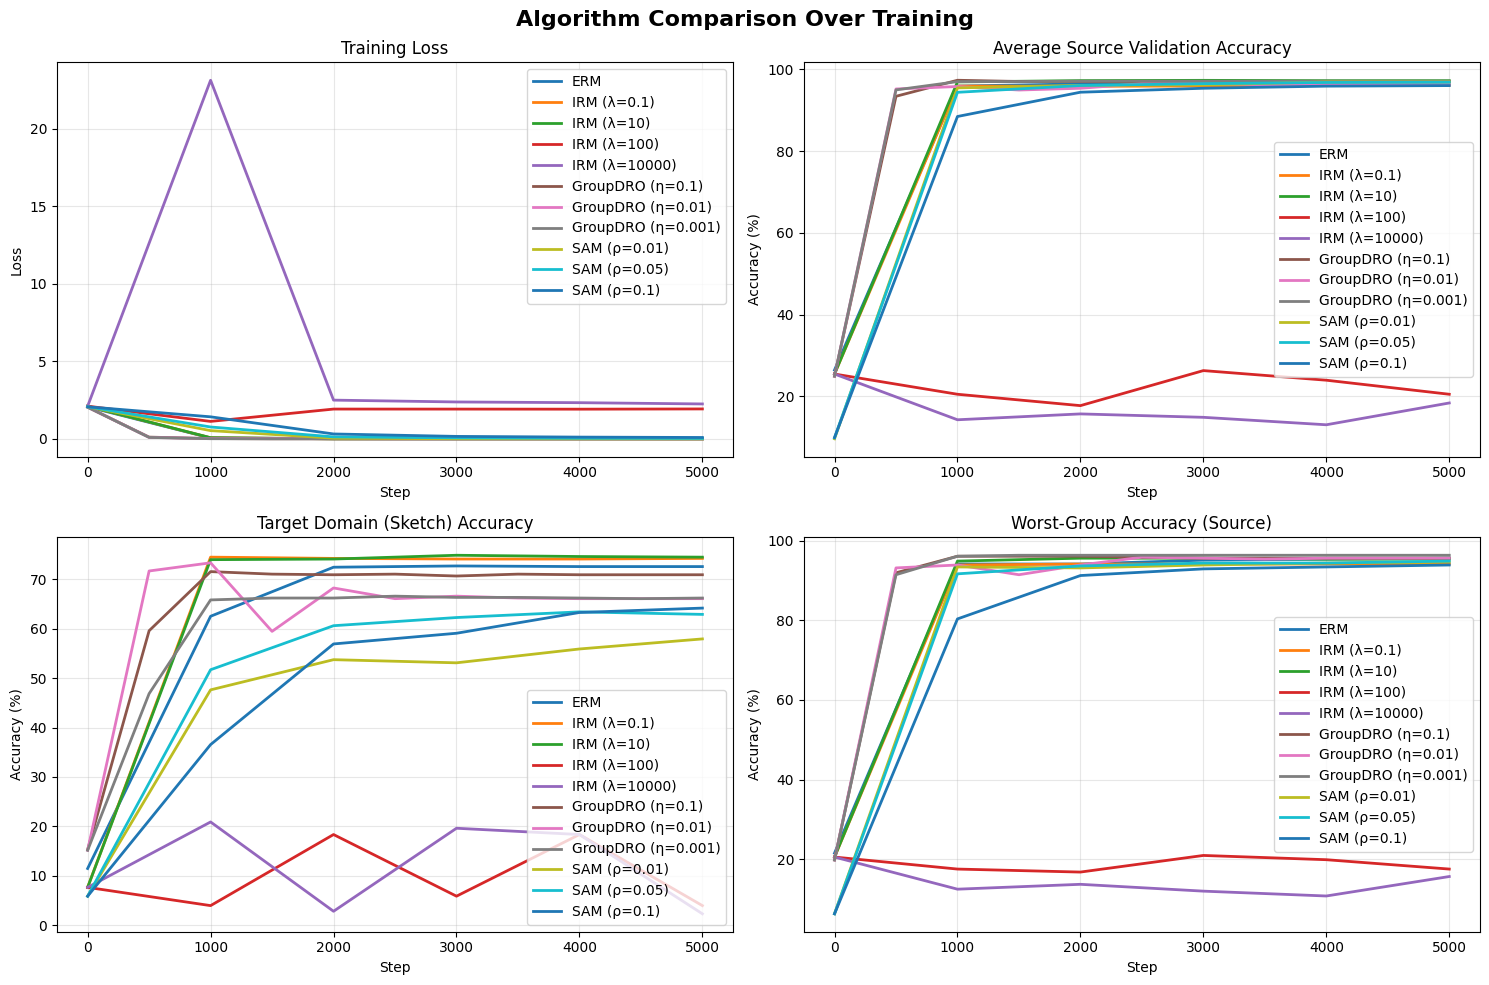


BEST CHECKPOINT SUMMARY
         Algorithm  Best Step Avg Source Val (%) Target Sketch (%) Worst Group (%) Photo (%) Art (%) Cartoon (%)
               ERM       3000              96.85             72.74           95.11     95.11   97.22       98.20
       IRM (λ=0.1)       1000              95.92             74.52           93.89     93.89   96.58       97.31
        IRM (λ=10)       3000              97.32             74.90           95.60     95.60   97.86       98.50
       IRM (λ=100)       2000              17.70             18.34           16.77     18.83   17.52       16.77
     IRM (λ=10000)       1000              14.25             20.89           12.47     12.47   17.09       13.17
  GroupDRO (η=0.1)       1000              97.34             71.59           96.09     96.09   97.44       98.50
 GroupDRO (η=0.01)       1000              95.81             73.38           93.89     93.89   95.94       97.60
GroupDRO (η=0.001)       2500              97.12             66.62     

In [5]:
def load_results_jsonl(filepath):
    """Load results from a JSONL file into a pandas DataFrame."""
    results = []
    with open(filepath, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    return pd.DataFrame(results)

def get_best_checkpoint_info(df):
    """Get information about the best checkpoint based on average source validation accuracy."""
    df['avg_source_val_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
    best_idx = df['env3_out_acc'].idxmax()
    best_row = df.iloc[best_idx]
    
    return {
        'step': int(best_row['step']),
        'epoch': best_row['epoch'],
        'avg_source_val_acc': best_row['avg_source_val_acc'] * 100,
        'target_acc': best_row['env3_out_acc'] * 100,
        'photo_acc': best_row['env0_out_acc'] * 100,
        'art_acc': best_row['env1_out_acc'] * 100,
        'cartoon_acc': best_row['env2_out_acc'] * 100,
        'worst_group_acc': min(best_row['env0_out_acc'], best_row['env1_out_acc'], best_row['env2_out_acc']) * 100,
        'loss': best_row['loss']
    }

# Compare multiple algorithms
print("\n" + "="*80)
print("COMPARING ALL ALGORITHMS")
print("="*80)

results_dict = {
    'ERM': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/erm_training/results.jsonl'),
    'IRM (λ=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_0.1_penalty/results.jsonl'),
    'IRM (λ=10)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10_penalty/results.jsonl'),
    'IRM (λ=100)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_100_penalty/results.jsonl'),
    'IRM (λ=10000)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10000_penalty/results.jsonl'),
    'GroupDRO (η=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.1_eta/results.jsonl'),
    'GroupDRO (η=0.01)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.01_eta/results.jsonl'),
    'GroupDRO (η=0.001)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.001_eta/results.jsonl'),
    'SAM (ρ=0.01)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.01_rho/results.jsonl'),
    'SAM (ρ=0.05)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.05_rho/results.jsonl'),
    'SAM (ρ=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.1_rho/results.jsonl')
}

compare_algorithms_over_time(results_dict)

# Create summary table of best checkpoints
print("\n" + "="*80)
print("BEST CHECKPOINT SUMMARY")
print("="*80)

summary_data = []
for algo_name, df in results_dict.items():
    best_info = get_best_checkpoint_info(df)
    summary_data.append({
        'Algorithm': algo_name,
        'Best Step': best_info['step'],
        'Avg Source Val (%)': f"{best_info['avg_source_val_acc']:.2f}",
        'Target Sketch (%)': f"{best_info['target_acc']:.2f}",
        'Worst Group (%)': f"{best_info['worst_group_acc']:.2f}",
        'Photo (%)': f"{best_info['photo_acc']:.2f}",
        'Art (%)': f"{best_info['art_acc']:.2f}",
        'Cartoon (%)': f"{best_info['cartoon_acc']:.2f}"
    })


summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

In [ ]:
# def measure_sharpness_gradient_based(model, dataloader, epsilon=0.01):
#     """
#     Measure sharpness by perturbing in the gradient direction (like SAM).
    
#     Args:
#         model: The trained model
#         dataloader: DataLoader to compute loss on
#         epsilon: Perturbation magnitude (relative to parameter norm)
    
#     Returns:
#         Dictionary with sharpness metrics
#     """
#     model.eval()
#     device = next(model.parameters()).device
    
#     # Get original loss and compute gradient
#     model.zero_grad()
#     original_loss = 0.0
#     num_batches = 0
    
#     # Compute loss and gradient on first batch (for efficiency)
#     for images, labels, _ in dataloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         loss = F.cross_entropy(outputs, labels)
#         loss.backward()
#         original_loss = loss.item()
#         num_batches = 1
#         break  # Only use first batch for gradient computation
    
#     # Store original parameters and gradients
#     original_params = []
#     perturbations = []
    
#     for p in model.parameters():
#         if p.requires_grad and p.grad is not None:
#             original_params.append(p.clone())
            
#             # Normalize gradient by parameter norm (like SAM)
#             grad = p.grad.clone()
#             param_norm = torch.norm(p)
#             grad_norm = torch.norm(grad)
            
#             if grad_norm > 0 and param_norm > 0:
#                 # Perturbation: epsilon * (gradient / ||gradient||) * ||parameter||
#                 perturbation = epsilon * (grad / grad_norm)
#             else:
#                 perturbation = torch.zeros_like(p)
            
#             perturbations.append(perturbation)
    
#     # Apply perturbation in gradient direction
#     with torch.no_grad():
#         for p, pert in zip([p for p in model.parameters() if p.requires_grad], perturbations):
#             p.add_(pert)
    
#     # Compute perturbed loss on full dataset
#     perturbed_loss = 0.0
#     num_batches = 0
#     with torch.no_grad():
#         for images, labels, _ in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             perturbed_loss += F.cross_entropy(outputs, labels).item()
#             num_batches += 1
#     perturbed_loss /= num_batches
    
#     # Restore original parameters
#     with torch.no_grad():
#         for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
#             p.copy_(orig_p)
    
#     loss_increase = perturbed_loss - original_loss
    
#     return {
#         'original_loss': original_loss,
#         'perturbed_loss': perturbed_loss,
#         'loss_increase': loss_increase,
#         'sharpness': loss_increase / original_loss if original_loss > 0 else 0,
#         'perturbation_norm': sum(torch.norm(p).item() for p in perturbations)
#     }

def measure_sharpness_gradient_based(model, dataloader, epsilon=0.01):
    """
    Measure sharpness by perturbing in the gradient direction (like SAM).
    
    Args:
        model: The trained model
        dataloader: DataLoader to compute loss on
        epsilon: Perturbation magnitude (rho parameter in SAM)
    
    Returns:
        Dictionary with sharpness metrics
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get original loss and compute gradient
    model.zero_grad()
    original_loss = 0.0
    
    # Compute loss and gradient on first batch (for efficiency)
    for images, labels, _ in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        original_loss = loss.item()
        break  # Only use first batch for gradient computation
    
    # Compute the L2 norm of all gradients (like SAM does)
    grad_norm = torch.norm(
        torch.stack([
            p.grad.norm(p=2).to(device)
            for p in model.parameters()
            if p.grad is not None
        ]),
        p=2
    )
    
    # Store original parameters and compute perturbations
    original_params = []
    perturbations = []
    
    scale = epsilon / (grad_norm + 1e-12)
    
    for p in model.parameters():
        if p.requires_grad and p.grad is not None:
            original_params.append(p.clone())
            
            perturbation = p.grad * scale
            perturbations.append(perturbation)
    
    with torch.no_grad():
        for p, pert in zip([p for p in model.parameters() if p.requires_grad], perturbations):
            p.add_(pert)
    
    perturbed_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            perturbed_loss += F.cross_entropy(outputs, labels).item()
            num_batches += 1
    perturbed_loss /= num_batches
    
    with torch.no_grad():
        for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
            p.copy_(orig_p)
    
    loss_increase = perturbed_loss - original_loss
    
    return {
        'original_loss': original_loss,
        'perturbed_loss': perturbed_loss,
        'loss_increase': loss_increase,
        'sharpness': loss_increase / original_loss if original_loss > 0 else 0,
        'perturbation_norm': sum(torch.norm(p).item() for p in perturbations),
        'grad_norm': grad_norm.item()
    }

In [ ]:
def measure_sharpness_vs_epsilon(model, dataloader, epsilon_range=None):
    """
    Measure sharpness across different epsilon values.
    
    Args:
        model: The trained model
        dataloader: DataLoader to compute loss on
        epsilon_range: List of epsilon values to test
    
    Returns:
        Dictionary with epsilon values and corresponding sharpness metrics
    """
    results = {
        'epsilons': [],
        'sharpness': [],
        'loss_increase': [],
        'perturbed_loss': []
    }
    
    for eps in epsilon_range:
        metrics = measure_sharpness_gradient_based(model, dataloader, epsilon=eps)
        results['epsilons'].append(eps)
        results['sharpness'].append(metrics['sharpness'])
        results['loss_increase'].append(metrics['loss_increase'])
        results['perturbed_loss'].append(metrics['perturbed_loss'])
    
    return results

# ERM
checkpoint = torch.load('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/erm_training/model_step5000.pkl')
ERM_Model = ERM(input_shape=checkpoint['model_input_shape'],
                num_classes=checkpoint['model_num_classes'],
                num_domains=checkpoint['model_num_domains'],
                hparams=checkpoint['model_hparams'])
ERM_Model.load_state_dict(checkpoint["model_dict"])
ERM_Model.to(DEVICE)
    
# SAM
sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
sam_resnet_pacs = sam_resnet_pacs.to(DEVICE)
sam_resnet_pacs.load_state_dict(torch.load('/home/csalt/Haider/ATML/ATML-PA 2/Task2_Models/best_sam_resnet_0_05.pth'))

print("\n" + "="*80)
print("SHARPNESS VS EPSILON ANALYSIS")
print("="*80)

# Define epsilon range
epsilon_range = np.linspace(1.0, 10.0, num=20)

print("\nMeasuring ERM sharpness across epsilon range...")
erm_results = measure_sharpness_vs_epsilon(ERM_Model.network, pacs_train_loader, epsilon_range)

print("Measuring SAM sharpness across epsilon range...")
sam_results = measure_sharpness_vs_epsilon(sam_resnet_pacs, pacs_train_loader, epsilon_range)

Loading best models for sharpness analysis...


/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



SHARPNESS VS EPSILON ANALYSIS

Measuring ERM sharpness across epsilon range...
Measuring SAM sharpness across epsilon range...


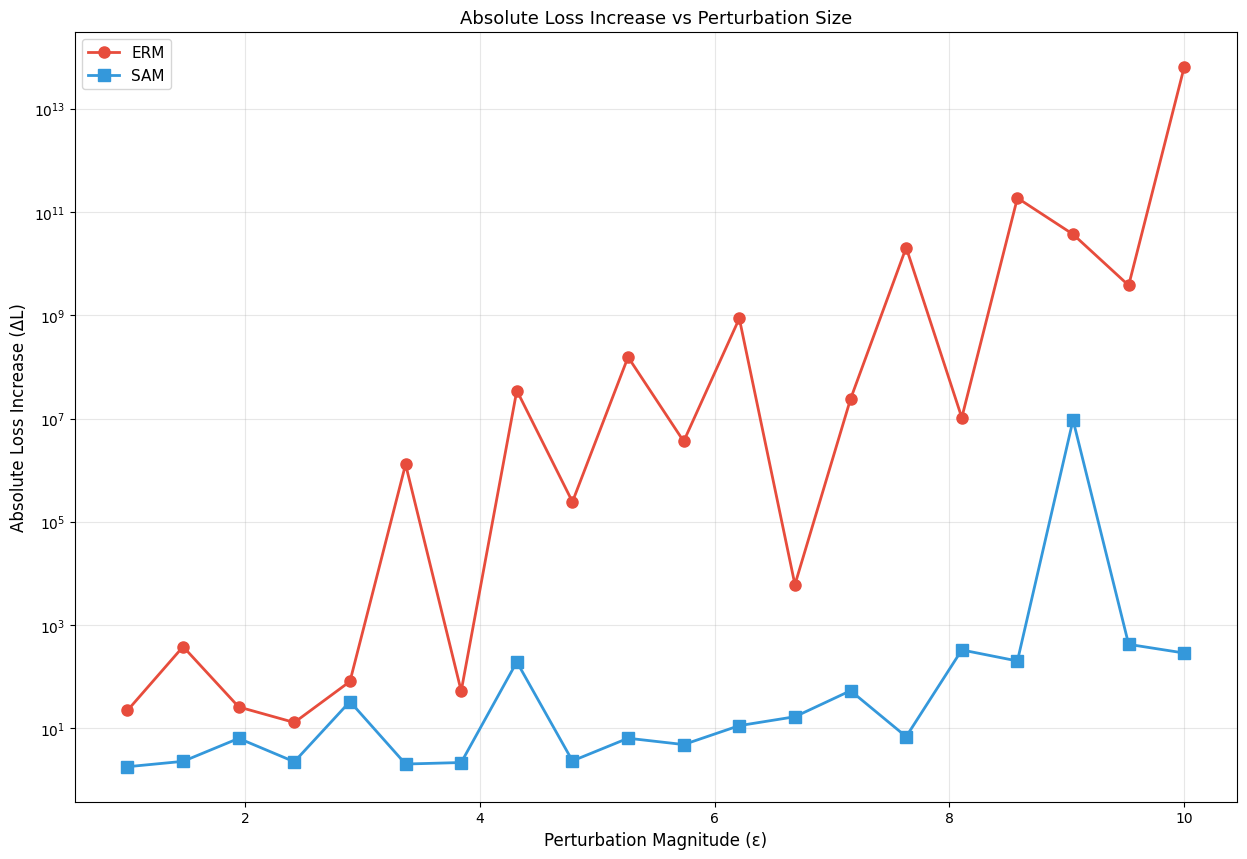

In [43]:
# Create visualization
plt.figure(figsize=(15, 10))
plt.title('Sharpness Analysis: ERM vs SAM', fontsize=16, fontweight='bold')

plt.plot(erm_results['epsilons'], erm_results['loss_increase'], 'o-', 
                linewidth=2, markersize=8, label='ERM', color='#e74c3c')
plt.plot(sam_results['epsilons'], sam_results['loss_increase'], 's-', 
                linewidth=2, markersize=8, label='SAM', color='#3498db')
plt.xlabel('Perturbation Magnitude (ε)', fontsize=12)
plt.ylabel('Absolute Loss Increase (ΔL)', fontsize=12)
plt.yscale('log')
plt.title('Absolute Loss Increase vs Perturbation Size', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.show()

In [46]:
# # Create visualization
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# fig.suptitle('Sharpness Analysis: ERM vs SAM', fontsize=16, fontweight='bold')

# # Plot 1: Normalized Sharpness vs Epsilon
# axes[0, 0].plot(erm_results['epsilons'], erm_results['sharpness'], 'o-', 
#                 linewidth=2, markersize=8, label='ERM', color='#e74c3c')
# axes[0, 0].plot(sam_results['epsilons'], sam_results['sharpness'], 's-', 
#                 linewidth=2, markersize=8, label='SAM', color='#3498db')
# axes[0, 0].set_xlabel('Perturbation Magnitude (ε)', fontsize=12)
# axes[0, 0].set_ylabel('Normalized Sharpness (ΔL/L₀)', fontsize=12)
# axes[0, 0].set_xscale('log')
# axes[0, 0].set_title('Normalized Sharpness vs Perturbation Size', fontsize=13)
# axes[0, 0].legend(fontsize=11)

# axes[0, 0].grid(True, alpha=0.3)

# # Plot 2: Absolute Loss Increase vs Epsilon
# axes[0, 1].plot(erm_results['epsilons'], erm_results['loss_increase'], 'o-', 
#                 linewidth=2, markersize=8, label='ERM', color='#e74c3c')
# axes[0, 1].plot(sam_results['epsilons'], sam_results['loss_increase'], 's-', 
#                 linewidth=2, markersize=8, label='SAM', color='#3498db')
# axes[0, 1].set_xlabel('Perturbation Magnitude (ε)', fontsize=12)
# axes[0, 1].set_ylabel('Absolute Loss Increase (ΔL)', fontsize=12)
# axes[0, 1].set_title('Absolute Loss Increase vs Perturbation Size', fontsize=13)
# axes[0, 1].legend(fontsize=11)
# axes[0, 1].grid(True, alpha=0.3)

# # Plot 3: Perturbed Loss vs Epsilon
# axes[1, 0].plot(erm_results['epsilons'], erm_results['perturbed_loss'], 'o-', 
#                 linewidth=2, markersize=8, label='ERM', color='#e74c3c')
# axes[1, 0].plot(sam_results['epsilons'], sam_results['perturbed_loss'], 's-', 
#                 linewidth=2, markersize=8, label='SAM', color='#3498db')
# axes[1, 0].set_xlabel('Perturbation Magnitude (ε)', fontsize=12)
# axes[1, 0].set_ylabel('Perturbed Loss', fontsize=12)
# axes[1, 0].set_title('Perturbed Loss vs Perturbation Size', fontsize=13)
# axes[1, 0].legend(fontsize=11)
# axes[1, 0].grid(True, alpha=0.3)

# # Plot 4: Sharpness Ratio (ERM/SAM) vs Epsilon
# sharpness_ratio = [e/s if s > 0 else 0 for e, s in zip(erm_results['sharpness'], sam_results['sharpness'])]
# axes[1, 1].plot(erm_results['epsilons'], sharpness_ratio, 'o-', 
#                 linewidth=2, markersize=8, color='#2ecc71')
# axes[1, 1].axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Equal sharpness')
# axes[1, 1].set_xlabel('Perturbation Magnitude (ε)', fontsize=12)
# axes[1, 1].set_ylabel('Sharpness Ratio (ERM/SAM)', fontsize=12)
# axes[1, 1].set_title('How Much Flatter is SAM? (Higher = SAM is flatter)', fontsize=13)
# axes[1, 1].legend(fontsize=11)
# axes[1, 1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [15]:
def measure_cross_domain_flatness(model, domain_loaders, epsilon=0.01, num_directions=10):
    """
    Measure cross-domain flatness: perturbations that hurt one domain should hurt all.
    Uses gradient-based perturbations (like SAM) computed on a combined batch from all domains.
    
    Returns correlation between loss increases across domains.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get original losses for each domain
    original_losses = {}
    for domain_name, loader in domain_loaders.items():
        loss = 0.0
        num_batches = 0
        with torch.no_grad():
            for images, labels, _ in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss += F.cross_entropy(outputs, labels).item()
                num_batches += 1
        original_losses[domain_name] = loss / num_batches
    
    # Store original parameters
    original_params = [p.clone() for p in model.parameters() if p.requires_grad]
    
    # Track loss increases per domain for each perturbation
    domain_increases = {domain: [] for domain in domain_loaders.keys()}
    
    for direction_idx in range(num_directions):
        # Compute gradient on a batch from all domains combined
        model.zero_grad()
        
        # Sample one batch from each domain and compute combined loss
        combined_loss = 0.0
        num_domains = 0
        for domain_name, loader in domain_loaders.items():
            # Get one batch from this domain
            for images, labels, _ in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                combined_loss += F.cross_entropy(outputs, labels)
                num_domains += 1
                break  # Only use first batch
        
        combined_loss /= num_domains
        combined_loss.backward()
        
        # Compute gradient norm (SAM-style)
        grad_norm = torch.norm(
            torch.stack([
                p.grad.norm(p=2).to(device)
                for p in model.parameters()
                if p.grad is not None
            ]),
            p=2
        )
        
        scale = epsilon / (grad_norm + 1e-12)
        
        # Apply gradient-based perturbation
        perturbations = []
        with torch.no_grad():
            for p in model.parameters():
                if p.requires_grad and p.grad is not None:
                    perturbation = p.grad * scale
                    perturbations.append(perturbation)
                    p.add_(perturbation)
        
        # Measure loss increase for each domain under this perturbation
        for domain_name, loader in domain_loaders.items():
            perturbed_loss = 0.0
            num_batches = 0
            with torch.no_grad():
                for images, labels, _ in loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    perturbed_loss += F.cross_entropy(outputs, labels).item()
                    num_batches += 1
            perturbed_loss /= num_batches
            
            domain_increases[domain_name].append(perturbed_loss - original_losses[domain_name])
        
        # Restore parameters for next iteration
        with torch.no_grad():
            for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
                p.copy_(orig_p)
    
    # Compute correlation matrix between domain loss increases
    domain_names = list(domain_loaders.keys())
    increases_array = np.array([domain_increases[d] for d in domain_names])
    correlation_matrix = np.corrcoef(increases_array)
    
    return {
        'domain_increases': domain_increases,
        'original_losses': original_losses
    }


CROSS-DOMAIN FLATNESS ANALYSIS

1. ERM
--------------------------------------------------------------------------------


/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Original Losses:
  photo: 0.0201
  art_painting: 0.0502
  cartoon: 0.0161
  sketch: 1.3616

Mean Loss Increase per Domain:
  photo: 0.0018 ± 0.0000
  art_painting: 0.0020 ± 0.0000
  cartoon: 0.0019 ± 0.0000
  sketch: 0.3824 ± 0.0000

2. IRM (λ=0.1)
--------------------------------------------------------------------------------
Original Losses:
  photo: 0.0280
  art_painting: 0.0547
  cartoon: 0.0468
  sketch: 1.1813

Mean Loss Increase per Domain:
  photo: 0.0019 ± 0.0000
  art_painting: 0.0009 ± 0.0000
  cartoon: 0.0009 ± 0.0000
  sketch: 0.3399 ± 0.0000

3. IRM (λ=10)
--------------------------------------------------------------------------------
Original Losses:
  photo: 0.0111
  art_painting: 0.0457
  cartoon: 0.0390
  sketch: 1.2228

Mean Loss Increase per Domain:
  photo: 0.0024 ± 0.0000
  art_painting: 0.0032 ± 0.0000
  cartoon: 0.0018 ± 0.0000
  sketch: 0.0115 ± 0.0000

4. IRM (λ=100)
--------------------------------------------------------------------------------
Original Lo

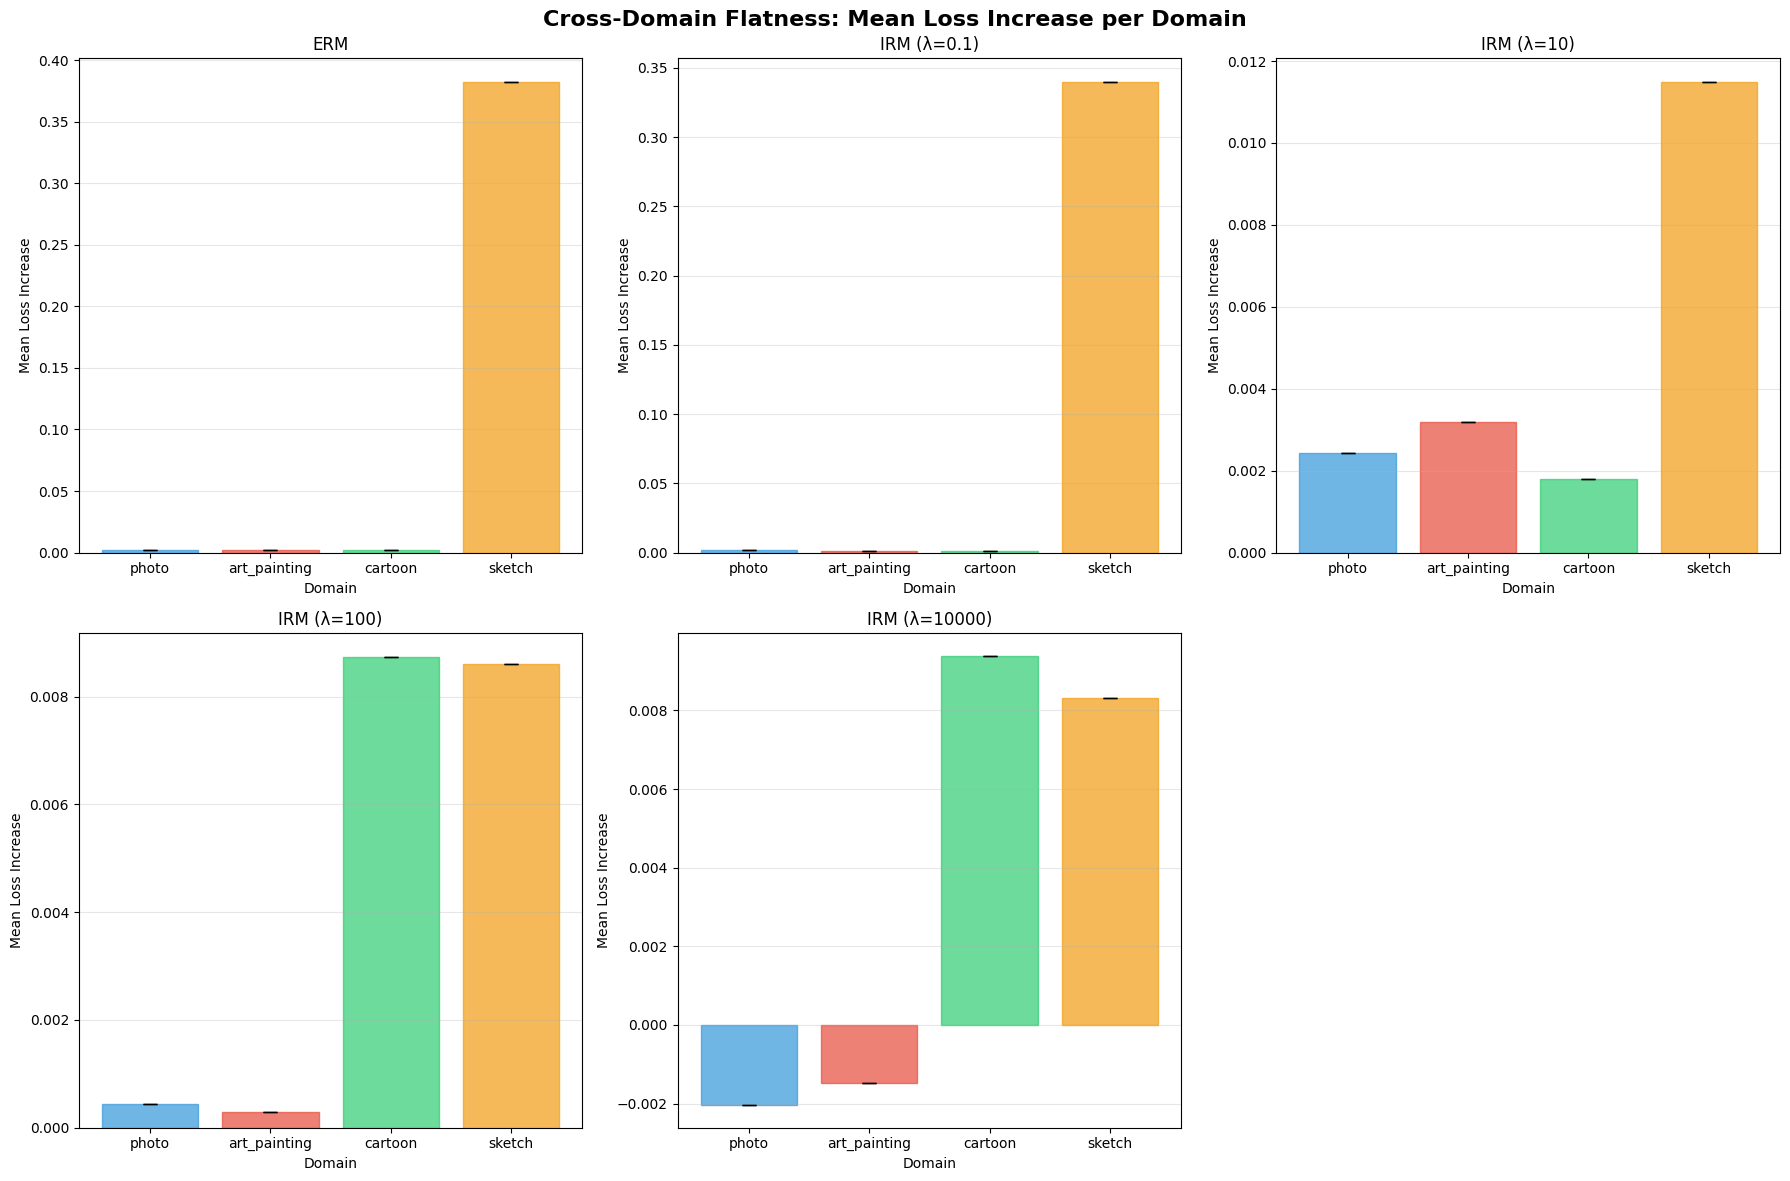


SUMMARY: CROSS-DOMAIN FLATNESS COMPARISON
        Model Photo Loss Art Loss Cartoon Loss Sketch Loss Avg Loss Increase Std Loss Increase
          ERM     0.0201   0.0502       0.0161      1.3616            0.0970            0.1648
  IRM (λ=0.1)     0.0280   0.0547       0.0468      1.1813            0.0859            0.1466
   IRM (λ=10)     0.0111   0.0457       0.0390      1.2228            0.0047            0.0039
  IRM (λ=100)     1.9265   1.9057       1.9052      2.0417            0.0045            0.0042
IRM (λ=10000)     1.9366   1.9281       1.9325      1.9473            0.0035            0.0053

➤ Lower mean loss increase = flatter solution
➤ Lower standard deviation = more consistent flatness across domains

SOURCE vs TARGET DOMAIN FLATNESS

ERM:
  Avg Source Loss Increase: 0.0019 ± 0.0001
  Avg Target Loss Increase: 0.3824 ± 0.0000
  Gap (Target - Source): +0.3805

IRM (λ=0.1):
  Avg Source Loss Increase: 0.0012 ± 0.0005
  Avg Target Loss Increase: 0.3399 ± 0.0000
  Gap (T

In [17]:
# Create domain loaders dictionary
domain_loaders_dict = {
    'photo': pacs_photo_loader,
    'art_painting': pacs_art_painting_loader,
    'cartoon': pacs_cartoon_loader,
    'sketch': pacs_test_loader
}

print("\n" + "="*80)
print("CROSS-DOMAIN FLATNESS ANALYSIS")
print("="*80)

# Store all results
all_flatness_results = {}

# Define models to analyze
models_to_analyze = [
    ('ERM', '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/erm_training/model_step5000.pkl', ERM),
    ('IRM (λ=0.1)', '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_0.1_penalty/model_step1000.pkl', IRM),
    ('IRM (λ=10)', '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10_penalty/model_step3000.pkl', IRM),
    ('IRM (λ=100)', '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_100_penalty/model_step2000.pkl', IRM),
    ('IRM (λ=10000)', '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10000_penalty/model_step1000.pkl', IRM),
]

# Analyze each model one by one
for idx, (model_name, checkpoint_path, model_class) in enumerate(models_to_analyze, 1):
    print(f"\n{idx}. {model_name}")
    print("-" * 80)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # Initialize model
    model = model_class(
        input_shape=checkpoint['model_input_shape'],
        num_classes=checkpoint['model_num_classes'],
        num_domains=checkpoint['model_num_domains'],
        hparams=checkpoint['model_hparams']
    )
    model.load_state_dict(checkpoint["model_dict"])
    model.to(DEVICE)
    
    # Measure cross-domain flatness
    flatness_results = measure_cross_domain_flatness(
        model.network,
        domain_loaders_dict,
        epsilon=0.01,
        num_directions=20
    )
    
    # Store results
    all_flatness_results[model_name] = flatness_results
    
    print(f"Original Losses:")
    for domain, loss in flatness_results['original_losses'].items():
        print(f"  {domain}: {loss:.4f}")
    
    print(f"\nMean Loss Increase per Domain:")
    for domain, increases in flatness_results['domain_increases'].items():
        print(f"  {domain}: {np.mean(increases):.4f} ± {np.std(increases):.4f}")
    
    # Clean up to free memory
    del model
    del checkpoint
    torch.cuda.empty_cache()
    
print("\n" + "="*80)
print("All models analyzed successfully!")
print("="*80)

# Now visualize all results
print("\n" + "="*80)
print("LOSS INCREASE VISUALIZATION")
print("="*80)

models_list = [
    'ERM',
    'IRM (λ=0.1)',
    'IRM (λ=10)',
    'IRM (λ=100)',
    'IRM (λ=10000)',
]

# Create bar plot comparing mean loss increases across domains
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cross-Domain Flatness: Mean Loss Increase per Domain', fontsize=16, fontweight='bold')

for idx, model_name in enumerate(models_list):
    flatness_data = all_flatness_results[model_name]
    ax = axes[idx // 3, idx % 3]
    
    domains = list(flatness_data['domain_increases'].keys())
    means = [np.mean(flatness_data['domain_increases'][d]) for d in domains]
    stds = [np.std(flatness_data['domain_increases'][d]) for d in domains]
    
    bars = ax.bar(domains, means, yerr=stds, capsize=5, alpha=0.7)
    ax.set_title(f"{model_name}")
    ax.set_ylabel('Mean Loss Increase')
    ax.set_xlabel('Domain')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Color bars by domain
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    for bar, color in zip(bars, colors):
        bar.set_color(color)

# Remove empty subplot
if len(models_list) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "="*80)
print("SUMMARY: CROSS-DOMAIN FLATNESS COMPARISON")
print("="*80)

summary_data = []
for model_name in models_list:
    flatness_data = all_flatness_results[model_name]
    
    # Calculate mean loss increase across all domains
    all_increases = []
    for increases in flatness_data['domain_increases'].values():
        all_increases.extend(increases)
    
    summary_data.append({
        'Model': model_name,
        'Photo Loss': f"{flatness_data['original_losses']['photo']:.4f}",
        'Art Loss': f"{flatness_data['original_losses']['art_painting']:.4f}",
        'Cartoon Loss': f"{flatness_data['original_losses']['cartoon']:.4f}",
        'Sketch Loss': f"{flatness_data['original_losses']['sketch']:.4f}",
        'Avg Loss Increase': f"{np.mean(all_increases):.4f}",
        'Std Loss Increase': f"{np.std(all_increases):.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n➤ Lower mean loss increase = flatter solution")
print("➤ Lower standard deviation = more consistent flatness across domains")

# Additional analysis: Compare source vs target domain flatness
print("\n" + "="*80)
print("SOURCE vs TARGET DOMAIN FLATNESS")
print("="*80)

for model_name in models_list:
    flatness_data = all_flatness_results[model_name]
    
    # Source domain increases
    source_increases = []
    for domain in ['photo', 'art_painting', 'cartoon']:
        source_increases.extend(flatness_data['domain_increases'][domain])
    
    # Target domain increases
    target_increases = flatness_data['domain_increases']['sketch']
    
    print(f"\n{model_name}:")
    print(f"  Avg Source Loss Increase: {np.mean(source_increases):.4f} ± {np.std(source_increases):.4f}")
    print(f"  Avg Target Loss Increase: {np.mean(target_increases):.4f} ± {np.std(target_increases):.4f}")
    print(f"  Gap (Target - Source): {np.mean(target_increases) - np.mean(source_increases):+.4f}")

print("\n➤ Smaller gap = better generalization to target domain")
print("➤ Negative gap = target domain is flatter than source domains")

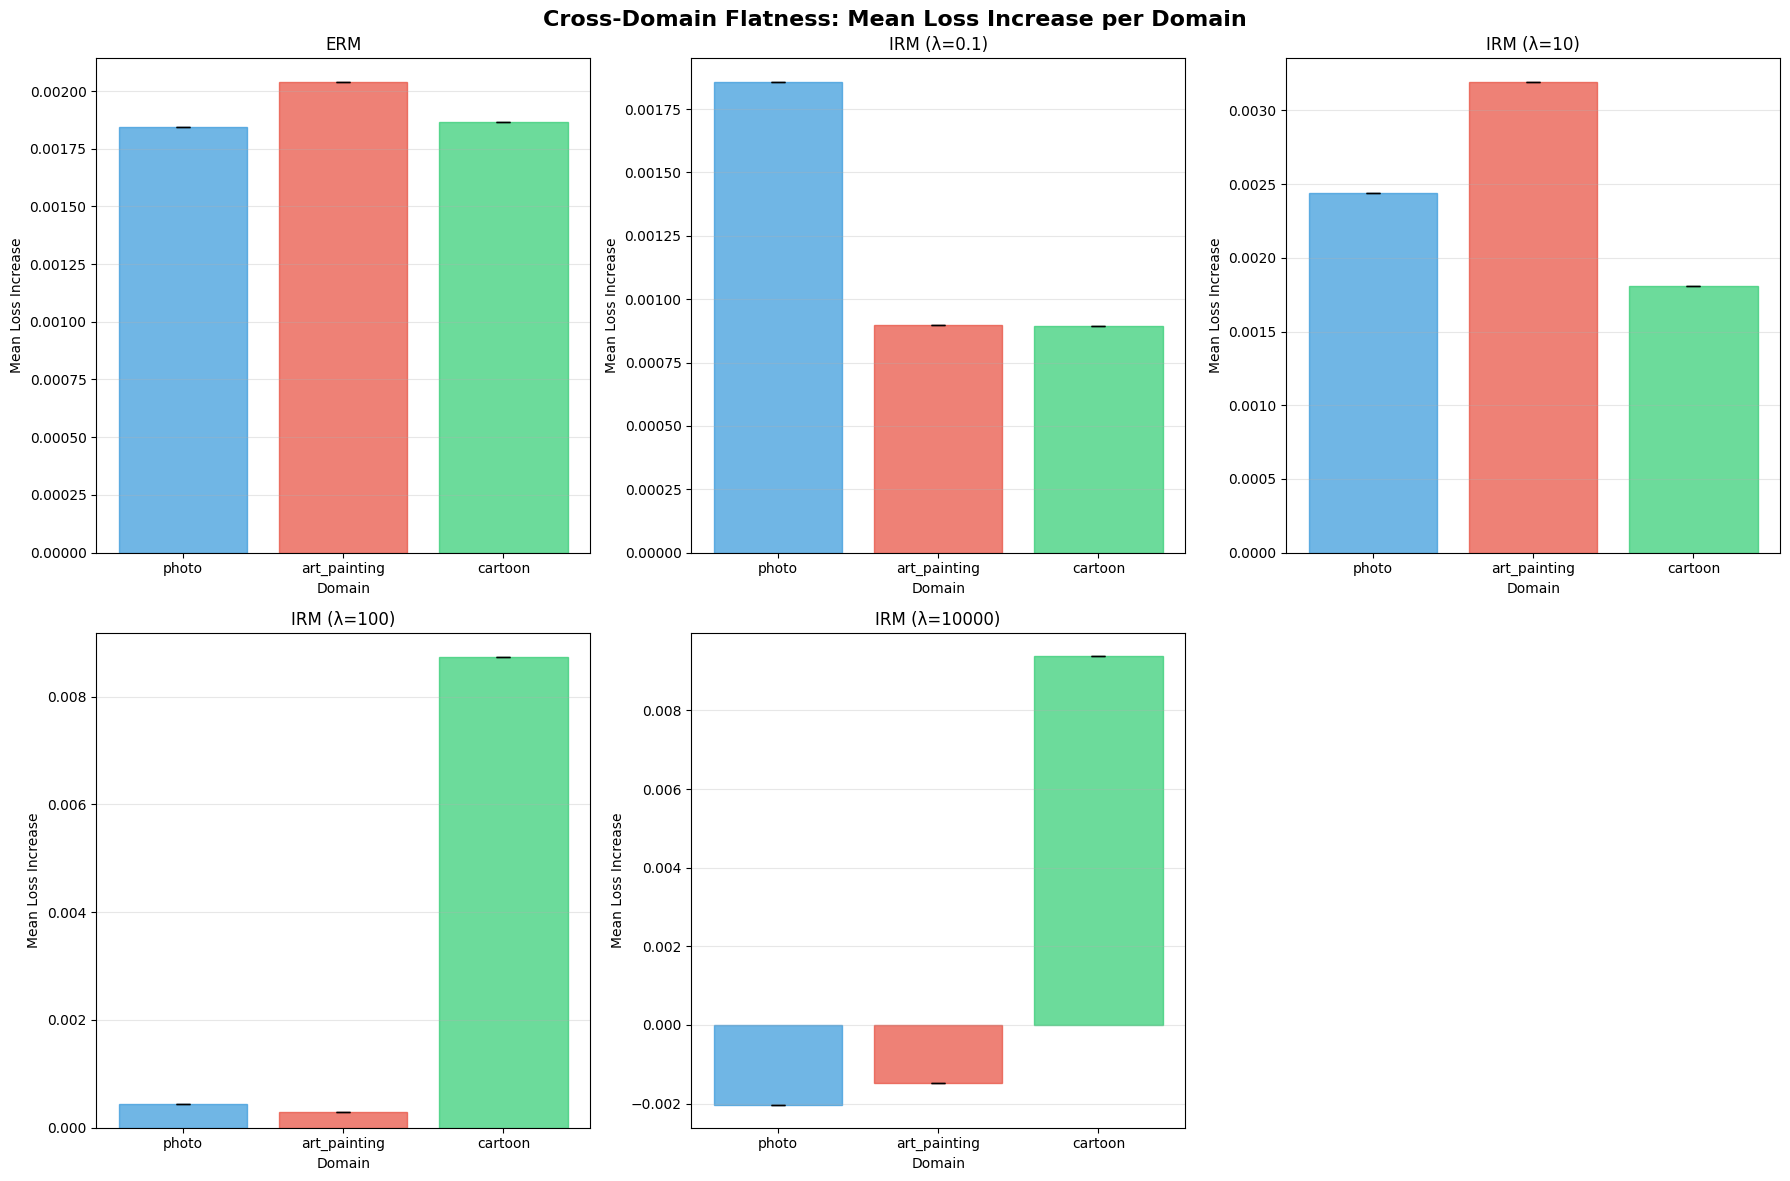

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cross-Domain Flatness: Mean Loss Increase per Domain', fontsize=16, fontweight='bold')

for idx, model_name in enumerate(models_list):
    flatness_data = all_flatness_results[model_name]
    ax = axes[idx // 3, idx % 3]
    
    domains = list(flatness_data['domain_increases'].keys())
    domains = [d for d in domains if d != 'sketch']
    means = [np.mean(flatness_data['domain_increases'][d]) for d in domains if d != 'sketch']
    stds = [np.std(flatness_data['domain_increases'][d]) for d in domains if d != 'sketch']
    
    bars = ax.bar(domains, means, yerr=stds, capsize=5, alpha=0.7)
    ax.set_title(f"{model_name}")
    ax.set_ylabel('Mean Loss Increase')
    ax.set_xlabel('Domain')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Color bars by domain
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    for bar, color in zip(bars, colors):
        bar.set_color(color)

# Remove empty subplot
if len(models_list) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


In [ ]:
def compute_loss_landscape_2d(model, dataloader, direction1, direction2, 
                               alpha_range=(-1, 1), beta_range=(-1, 1), 
                               steps=20):
    """
    Compute 2D loss landscape by moving in two random directions.
    
    Args:
        model: The model to analyze
        dataloader: Data to compute loss on
        direction1, direction2: List of parameter perturbations (same structure as model params)
        alpha_range, beta_range: Range for each direction
        steps: Number of points to sample in each direction
    
    Returns:
        alphas, betas, losses (meshgrid for plotting)
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Store original parameters
    original_params = [p.clone() for p in model.parameters() if p.requires_grad]
    
    # Create grid
    alphas = np.linspace(alpha_range[0], alpha_range[1], steps)
    betas = np.linspace(beta_range[0], beta_range[1], steps)
    losses = np.zeros((len(betas), len(alphas)))
    
    # Compute loss at each grid point
    for i, beta in enumerate(betas):
        for j, alpha in enumerate(alphas):
            # Perturb parameters: θ = θ_0 + α*d1 + β*d2
            with torch.no_grad():
                for p, orig_p, d1, d2 in zip([p for p in model.parameters() if p.requires_grad], 
                                              original_params, direction1, direction2):
                    p.copy_(orig_p + alpha * d1 + beta * d2)
            
            # Compute loss
            loss = 0.0
            num_batches = 0
            with torch.no_grad():
                for images, labels, _ in dataloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss += F.cross_entropy(outputs, labels).item()
                    num_batches += 1
                    if num_batches >= 10:  # Limit batches for speed
                        break
            losses[i, j] = loss / num_batches
    
    # Restore original parameters
    with torch.no_grad():
        for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
            p.copy_(orig_p)
    
    return alphas, betas, losses

def generate_random_directions(model, num_directions=2):
    """Generate random directions for loss landscape visualization."""
    directions = []
    for _ in range(num_directions):
        direction = []
        for p in model.parameters():
            if p.requires_grad:
                # Random direction normalized to unit norm
                d = torch.randn_like(p)
                d = d / torch.norm(d)
                direction.append(d)
        directions.append(direction)
    return directions

def visualize_loss_landscape(model, dataloader, model_name="Model", 
                             alpha_range=(-0.5, 0.5), beta_range=(-0.5, 0.5), 
                             steps=20):
    """
    Create 2D visualization of loss landscape.
    """
    print(f"Computing loss landscape for {model_name}...")
    
    # Generate two random directions
    directions = generate_random_directions(model, num_directions=2)
    direction1, direction2 = directions[0], directions[1]
    
    # Compute landscape
    alphas, betas, losses = compute_loss_landscape_2d(
        model, dataloader, direction1, direction2,
        alpha_range, beta_range, steps
    )
    
    # Plot
    fig = plt.figure(figsize=(14, 5))
    
    # 3D surface plot
    ax1 = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(alphas, betas)
    surf = ax1.plot_surface(X, Y, losses, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Direction 1 (α)')
    ax1.set_ylabel('Direction 2 (β)')
    ax1.set_zlabel('Loss')
    ax1.set_title(f'{model_name} - Loss Surface')
    fig.colorbar(surf, ax=ax1, shrink=0.5)
    
    # Contour plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X, Y, losses, levels=20, cmap='viridis')
    ax2.contour(X, Y, losses, levels=10, colors='black', alpha=0.3, linewidths=0.5)
    ax2.plot(0, 0, 'r*', markersize=15, label='Current solution')
    ax2.set_xlabel('Direction 1 (α)')
    ax2.set_ylabel('Direction 2 (β)')
    ax2.set_title(f'{model_name} - Loss Contours')
    ax2.legend()
    fig.colorbar(contour, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    return alphas, betas, losses


/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



3. LOSS LANDSCAPE VISUALIZATION
--------------------------------------------------------------------------------

Visualizing ERM loss landscape...
Computing loss landscape for ERM...


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 416, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 416, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
TypeError: 'DataLoader' object is not subscriptable



Improved Loss Landscape Visualization
Computing loss landscape for ERM...


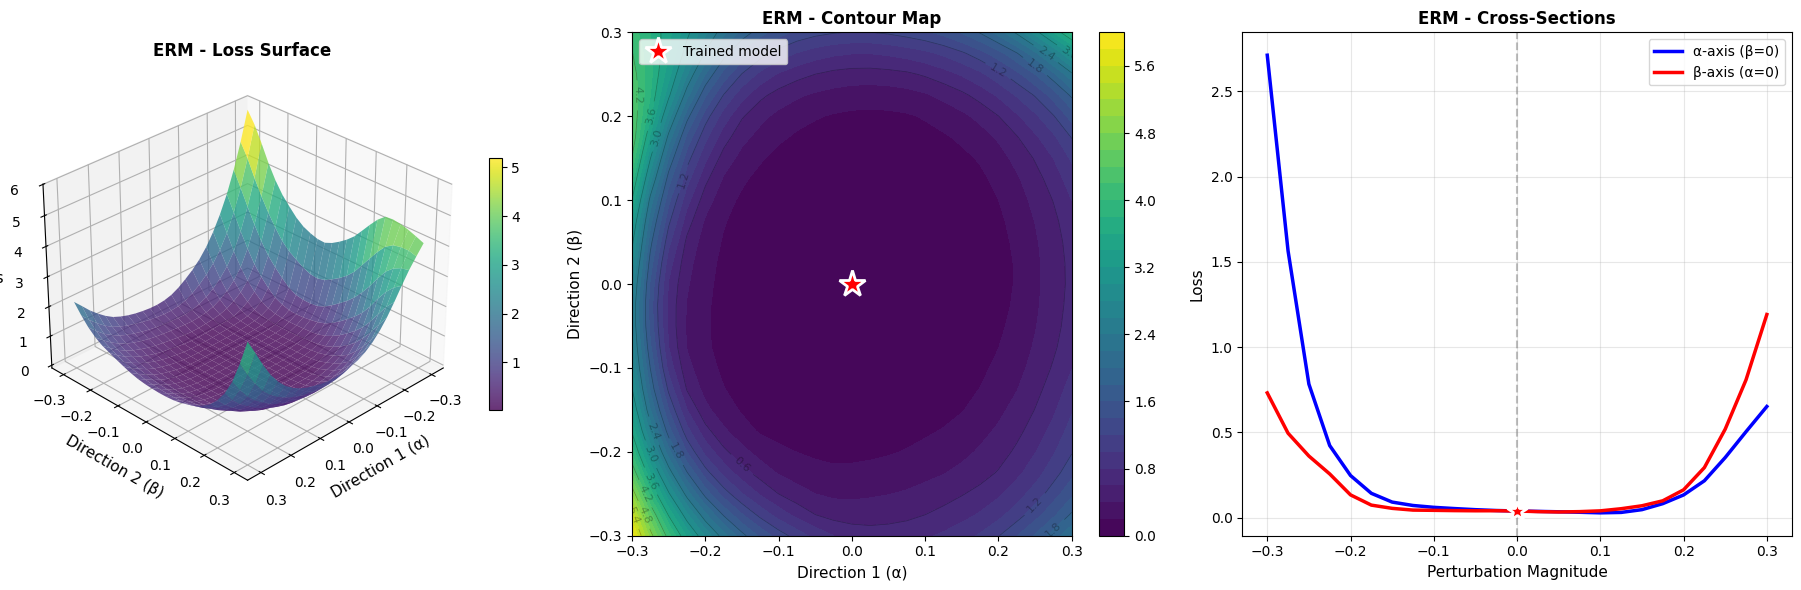

Computing loss landscape for SAM...


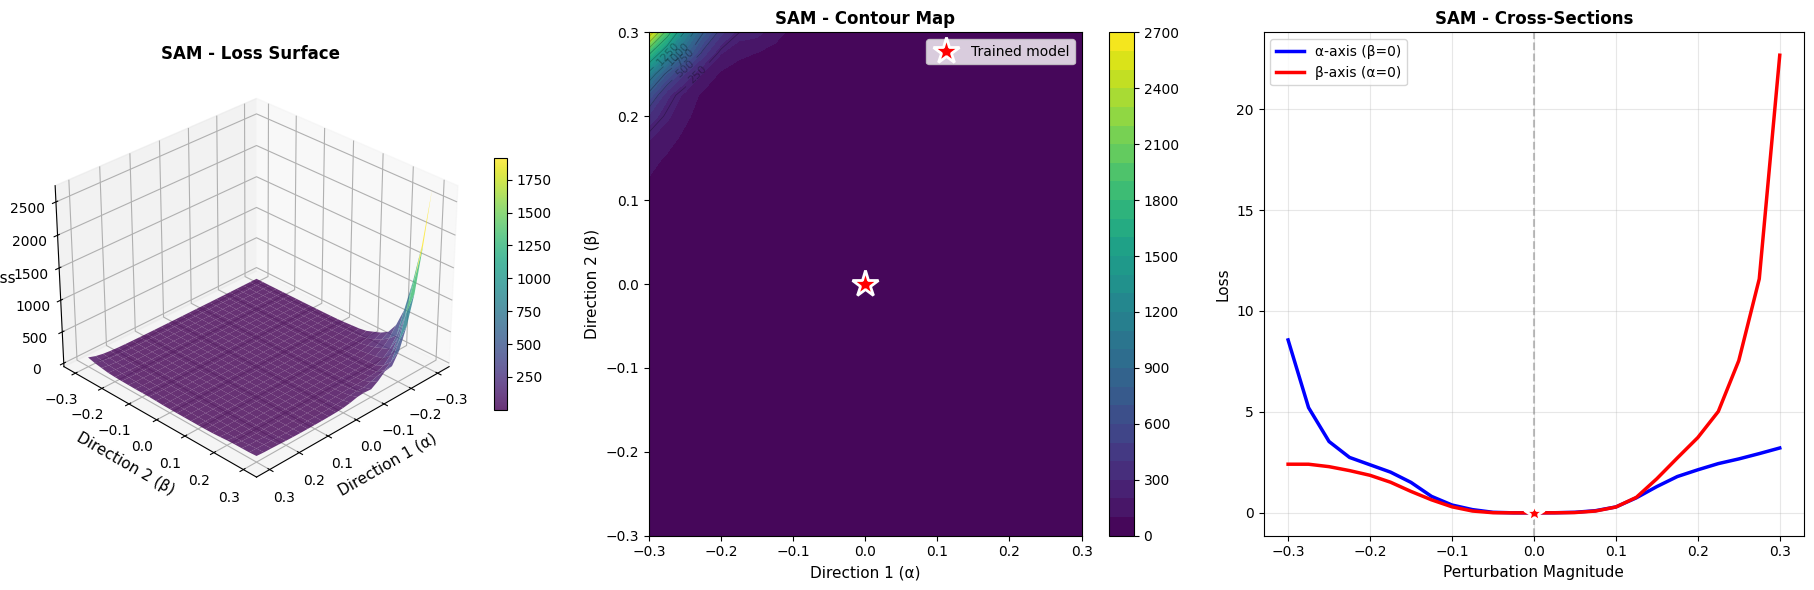

In [27]:
# Use filter-normalized directions for fair comparison
def generate_filter_normalized_directions(model):
    """Generate directions with filter normalization (Li et al., 2018)"""
    directions = []
    for _ in range(2):
        direction = []
        for p in model.parameters():
            if p.requires_grad:
                d = torch.randn_like(p)
                # Normalize each filter separately
                if len(p.shape) >= 2:  # Conv or Linear layer
                    for i in range(p.shape[0]):
                        filter_norm = torch.norm(p[i])
                        d_norm = torch.norm(d[i])
                        if d_norm > 0:
                            d[i] = d[i] / d_norm * filter_norm
                else:  # Bias or 1D params
                    d = d / torch.norm(d) * torch.norm(p)
                direction.append(d)
        directions.append(direction)
    return directions

def visualize_loss_landscape_improved(model, dataloader, model_name="Model",
                                     alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3),
                                     steps=25, use_gradient_dirs=False):
    """
    Improved loss landscape visualization.
    
    Args:
        use_gradient_dirs: If True, use gradient directions; else use filter-normalized random
    """
    print(f"Computing loss landscape for {model_name}...")
    
  
    directions = generate_filter_normalized_directions(model)
    
    direction1, direction2 = directions[0], directions[1]
    
    # Compute landscape
    alphas, betas, losses = compute_loss_landscape_2d(
        model, dataloader, direction1, direction2,
        alpha_range, beta_range, steps
    )
    
    # Plot with better visualization
    fig = plt.figure(figsize=(18, 6))
    
    # 3D surface
    ax1 = fig.add_subplot(131, projection='3d')
    X, Y = np.meshgrid(alphas, betas)
    surf = ax1.plot_surface(X, Y, losses, cmap='viridis', alpha=0.8, edgecolor='none')
    ax1.set_xlabel('Direction 1 (α)', fontsize=11)
    ax1.set_ylabel('Direction 2 (β)', fontsize=11)
    ax1.set_zlabel('Loss', fontsize=11)
    ax1.set_title(f'{model_name} - Loss Surface', fontsize=12, fontweight='bold')
    fig.colorbar(surf, ax=ax1, shrink=0.5)
    ax1.view_init(elev=30, azim=45)
    
    # Contour plot
    ax2 = fig.add_subplot(132)
    contour = ax2.contourf(X, Y, losses, levels=30, cmap='viridis')
    contour_lines = ax2.contour(X, Y, losses, levels=10, colors='black', alpha=0.3, linewidths=0.5)
    ax2.clabel(contour_lines, inline=True, fontsize=8)
    ax2.plot(0, 0, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2, label='Trained model')
    ax2.set_xlabel('Direction 1 (α)', fontsize=11)
    ax2.set_ylabel('Direction 2 (β)', fontsize=11)
    ax2.set_title(f'{model_name} - Contour Map', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    fig.colorbar(contour, ax=ax2)
    
    # Cross-section plot
    ax3 = fig.add_subplot(133)
    center_i, center_j = len(betas) // 2, len(alphas) // 2
    ax3.plot(alphas, losses[center_i, :], 'b-', linewidth=2.5, label='α-axis (β=0)')
    ax3.plot(betas, losses[:, center_j], 'r-', linewidth=2.5, label='β-axis (α=0)')
    ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax3.plot(0, losses[center_i, center_j], 'r*', markersize=15, markeredgecolor='white', markeredgewidth=2)
    ax3.set_xlabel('Perturbation Magnitude', fontsize=11)
    ax3.set_ylabel('Loss', fontsize=11)
    ax3.set_title(f'{model_name} - Cross-Sections', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return alphas, betas, losses

# Compare ERM vs SAM with improved visualization
print("\nImproved Loss Landscape Visualization")
print("=" * 80)

erm_alphas, erm_betas, erm_losses = visualize_loss_landscape_improved(
    ERM_Model.network, val_subset_loader, model_name="ERM",
    alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3), steps=25
)

sam_alphas, sam_betas, sam_losses = visualize_loss_landscape_improved(
    sam_resnet_pacs, val_subset_loader, model_name="SAM",
    alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3), steps=25
)


3. LOSS LANDSCAPE VISUALIZATION
--------------------------------------------------------------------------------

Visualizing ERM loss landscape...
Computing loss landscape for ERM...


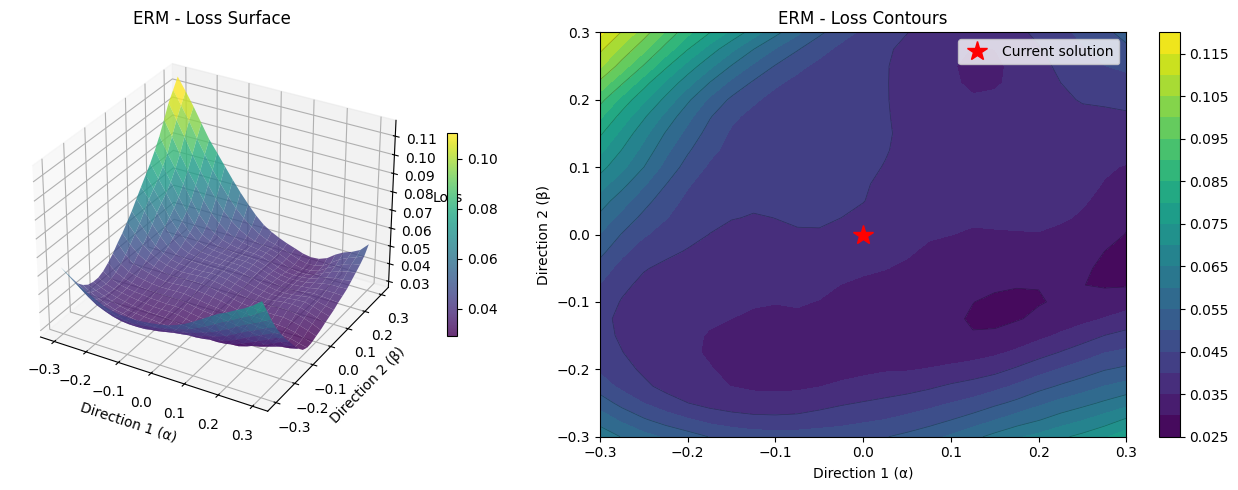


Visualizing SAM loss landscape...
Computing loss landscape for SAM...


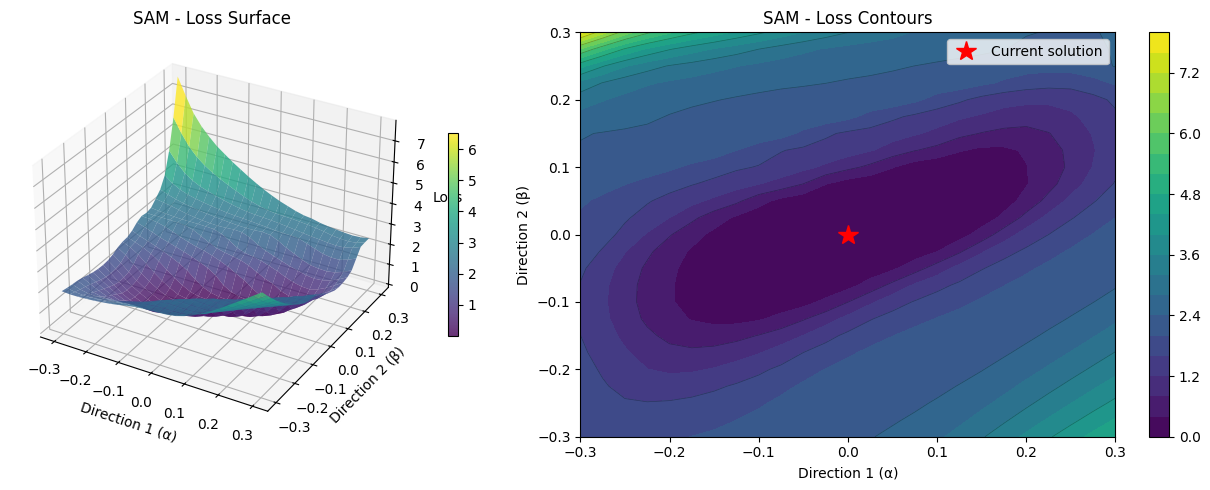


4. QUANTITATIVE COMPARISON
--------------------------------------------------------------------------------
ERM Local Curvature: 0.0010
SAM Local Curvature: 0.0002
➤ SAM has 5.19x flatter local region!


In [23]:
checkpoint = torch.load('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/erm_training/model_step5000.pkl')
ERM_Model = ERM(input_shape=checkpoint['model_input_shape'],
                num_classes=checkpoint['model_num_classes'],
                num_domains=checkpoint['model_num_domains'],
                hparams=checkpoint['model_hparams'])
ERM_Model.load_state_dict(checkpoint["model_dict"])
ERM_Model.to(DEVICE)
    
# SAM
sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
sam_resnet_pacs = sam_resnet_pacs.to(DEVICE)
sam_resnet_pacs.load_state_dict(torch.load('/home/csalt/Haider/ATML/ATML-PA 2/Task2_Models/best_sam_resnet_0_05.pth'))

print("\n3. LOSS LANDSCAPE VISUALIZATION")
print("-" * 80)

# Use a subset of training data for speed - FIXED: Use the dataset, not the loader
val_subset_size = 500
val_subset_indices = torch.randperm(len(pacs_train))[:val_subset_size]
val_subset = torch.utils.data.Subset(pacs_train, val_subset_indices)
val_subset_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

print("\nVisualizing ERM loss landscape...")
erm_alphas, erm_betas, erm_losses = visualize_loss_landscape(
    ERM_Model.network, val_subset_loader, model_name="ERM",
    alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3), steps=25
)

print("\nVisualizing SAM loss landscape...")
sam_alphas, sam_betas, sam_losses = visualize_loss_landscape(
    sam_resnet_pacs, val_subset_loader, model_name="SAM",
    alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3), steps=25
)

# Compare flatness: compute average gradient magnitude around minimum
print("\n4. QUANTITATIVE COMPARISON")
print("-" * 80)

def compute_local_curvature(losses):
    """Compute average absolute gradient magnitude around center."""
    center_i, center_j = losses.shape[0] // 2, losses.shape[1] // 2
    gradients = []
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue
            i, j = center_i + di, center_j + dj
            if 0 <= i < losses.shape[0] and 0 <= j < losses.shape[1]:
                gradients.append(abs(losses[i, j] - losses[center_i, center_j]))
    return np.mean(gradients)

erm_curvature = compute_local_curvature(erm_losses)
sam_curvature = compute_local_curvature(sam_losses)

print(f"ERM Local Curvature: {erm_curvature:.4f}")
print(f"SAM Local Curvature: {sam_curvature:.4f}")
print(f"➤ SAM has {(erm_curvature / sam_curvature):.2f}x flatter local region!")

# GDRO

Loaded 11 checkpoints for η=0.001
Loaded 11 checkpoints for η=0.01
Loaded 11 checkpoints for η=0.1

GROUP DRO WEIGHT EVOLUTION ANALYSIS


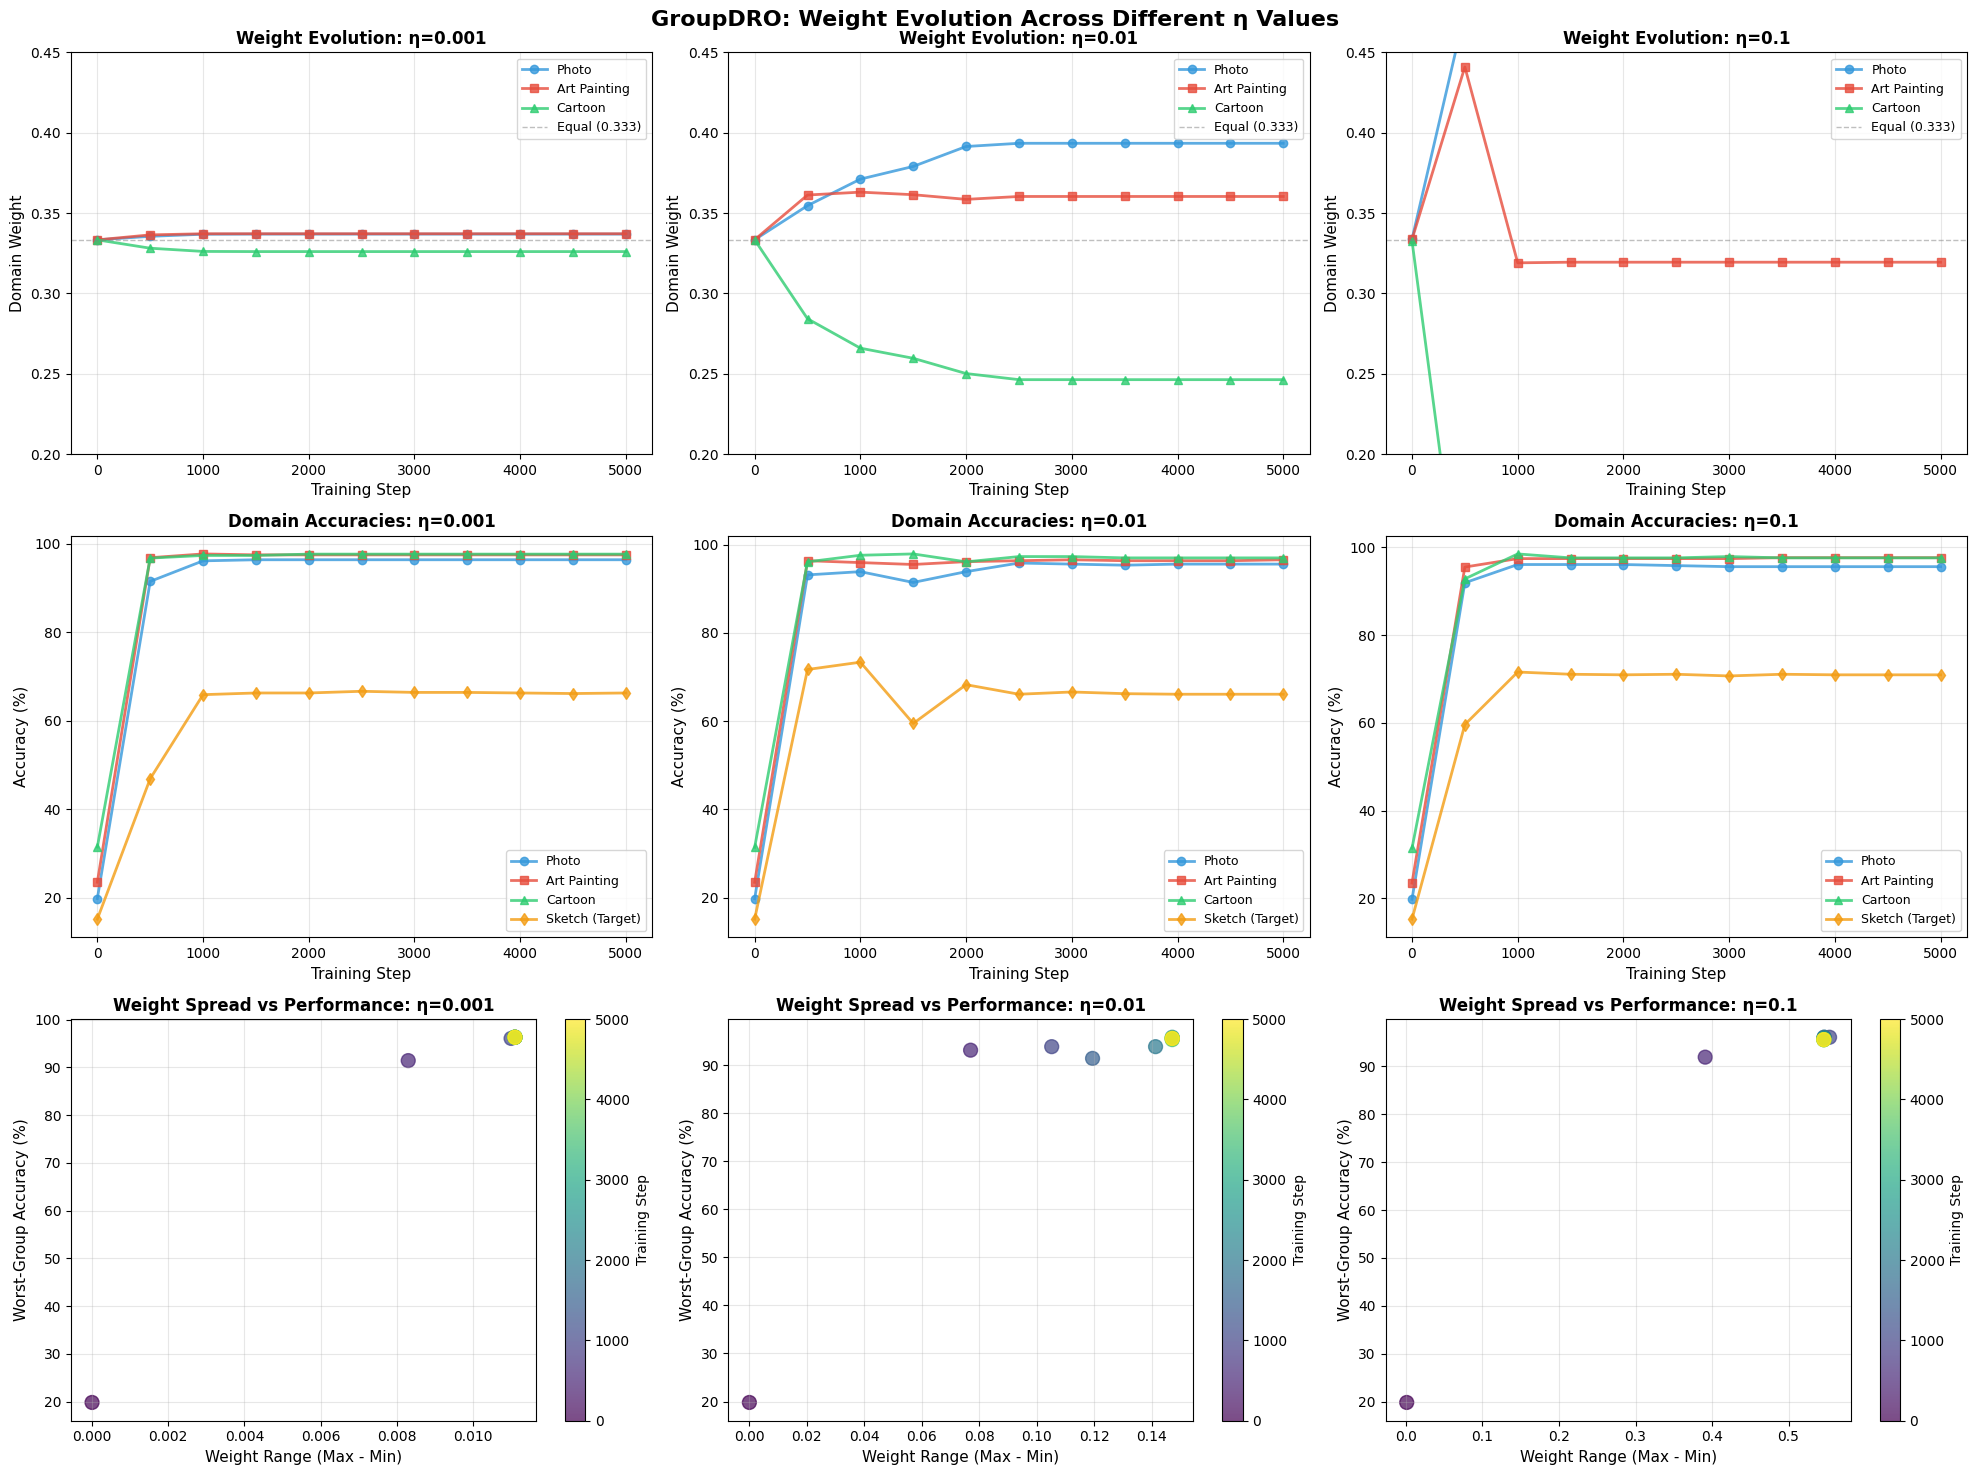


WEIGHT EVOLUTION SUMMARY

η=0.001:
  Initial weights: Photo=0.3333, Art=0.3333, Cartoon=0.3333
  Final weights:   Photo=0.3369, Art=0.3371, Cartoon=0.3260
  Highest weight domain: Art Painting (0.3371)
  Lowest weight domain:  Cartoon (0.3260)
  Weight spread (max-min): 0.0111
  Final worst-group acc: 96.33%
  Final avg source acc:  97.12%
  Final target acc:      66.24%

η=0.01:
  Initial weights: Photo=0.3334, Art=0.3334, Cartoon=0.3333
  Final weights:   Photo=0.3934, Art=0.3603, Cartoon=0.2463
  Highest weight domain: Photo (0.3934)
  Lowest weight domain:  Cartoon (0.2463)
  Weight spread (max-min): 0.1471
  Final worst-group acc: 95.60%
  Final avg source acc:  96.40%
  Final target acc:      66.11%

η=0.1:
  Initial weights: Photo=0.3337, Art=0.3336, Cartoon=0.3327
  Final weights:   Photo=0.6133, Art=0.3194, Cartoon=0.0672
  Highest weight domain: Photo (0.6133)
  Lowest weight domain:  Cartoon (0.0672)
  Weight spread (max-min): 0.5461
  Final worst-group acc: 95.60%
  Final 

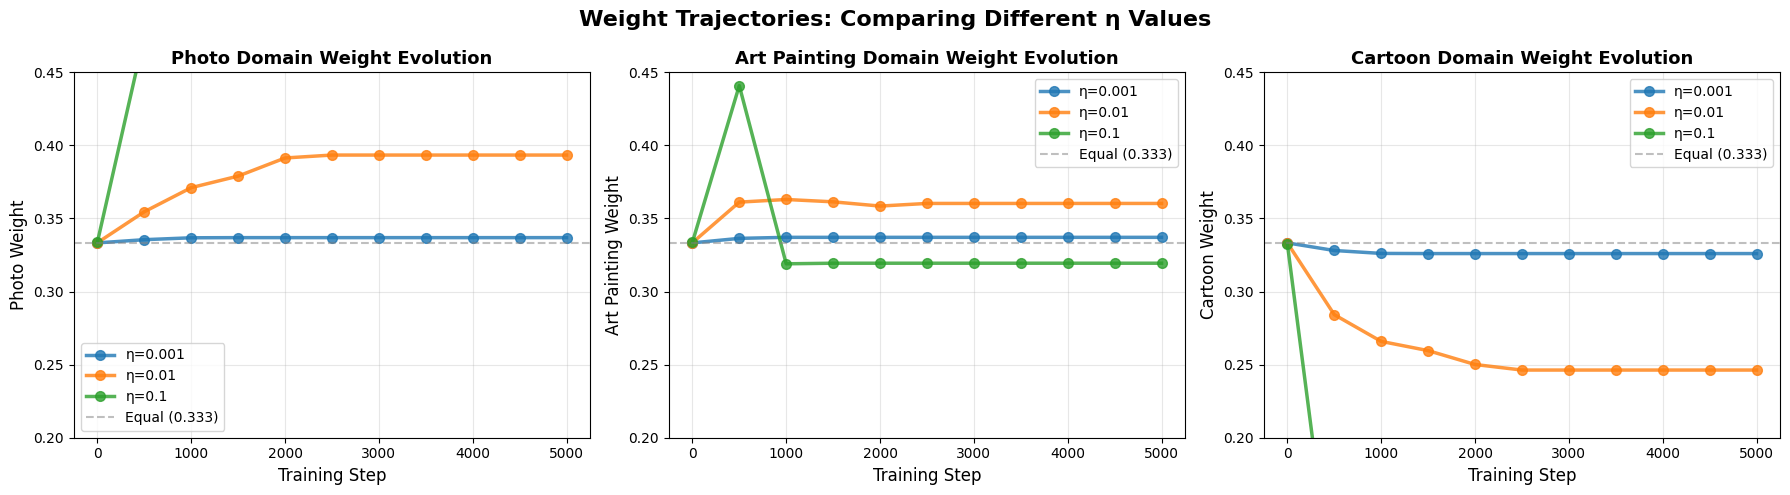


WEIGHT-ACCURACY CORRELATION ANALYSIS

η=0.001:
  Photo weight ↔ Photo accuracy:     +0.950
  Art weight ↔ Art accuracy:         +0.985
  Cartoon weight ↔ Cartoon accuracy: -0.963
  ✓ Negative correlation detected: GroupDRO is upweighting harder domains!

η=0.01:
  Photo weight ↔ Photo accuracy:     +0.803
  Art weight ↔ Art accuracy:         +0.991
  Cartoon weight ↔ Cartoon accuracy: -0.896
  ✓ Negative correlation detected: GroupDRO is upweighting harder domains!

η=0.1:
  Photo weight ↔ Photo accuracy:     +0.910
  Art weight ↔ Art accuracy:         -0.044
  Cartoon weight ↔ Cartoon accuracy: -1.000
  ✓ Negative correlation detected: GroupDRO is upweighting harder domains!


In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_gdro_results(filepath):
    """Load GDRO results from a JSONL file."""
    results = []
    with open(filepath, 'r') as f:
        for line in f:
            data = json.loads(line)
            if 'weights' in data:
                results.append({
                    'step': data['step'],
                    'epoch': data['epoch'],
                    'loss': data['loss'],
                    'weight_photo': data['weights'][0],
                    'weight_art': data['weights'][1],
                    'weight_cartoon': data['weights'][2],
                    'env0_out_acc': data['env0_out_acc'],
                    'env1_out_acc': data['env1_out_acc'],
                    'env2_out_acc': data['env2_out_acc'],
                    'env3_out_acc': data['env3_out_acc']
                })
    return pd.DataFrame(results)

# Load results for different eta values
gdro_paths = {
    'η=0.001': '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.001_eta/results.jsonl',
    'η=0.01': '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.01_eta/results.jsonl',
    'η=0.1': '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.1_eta/results.jsonl',
}

gdro_results = {}
for eta_name, path in gdro_paths.items():
    gdro_results[eta_name] = load_gdro_results(path)
    print(f"Loaded {len(gdro_results[eta_name])} checkpoints for {eta_name}")

print("\n" + "="*80)
print("GROUP DRO WEIGHT EVOLUTION ANALYSIS")
print("="*80)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('GroupDRO: Weight Evolution Across Different η Values', fontsize=16, fontweight='bold')

eta_names = list(gdro_results.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71']
domain_names = ['Photo', 'Art Painting', 'Cartoon']

# Plot 1-3: Weight evolution for each eta
for idx, eta_name in enumerate(eta_names):
    df = gdro_results[eta_name]
    ax = axes[0, idx]
    
    ax.plot(df['step'], df['weight_photo'], 'o-', color=colors[0], 
            linewidth=2, markersize=6, label='Photo', alpha=0.8)
    ax.plot(df['step'], df['weight_art'], 's-', color=colors[1], 
            linewidth=2, markersize=6, label='Art Painting', alpha=0.8)
    ax.plot(df['step'], df['weight_cartoon'], '^-', color=colors[2], 
            linewidth=2, markersize=6, label='Cartoon', alpha=0.8)
    
    ax.axhline(y=1/3, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Equal (0.333)')
    ax.set_xlabel('Training Step', fontsize=11)
    ax.set_ylabel('Domain Weight', fontsize=11)
    ax.set_title(f'Weight Evolution: {eta_name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.2, 0.45])

# Plot 4-6: Domain accuracies over time
for idx, eta_name in enumerate(eta_names):
    df = gdro_results[eta_name]
    ax = axes[1, idx]
    
    ax.plot(df['step'], df['env0_out_acc'] * 100, 'o-', color=colors[0], 
            linewidth=2, markersize=6, label='Photo', alpha=0.8)
    ax.plot(df['step'], df['env1_out_acc'] * 100, 's-', color=colors[1], 
            linewidth=2, markersize=6, label='Art Painting', alpha=0.8)
    ax.plot(df['step'], df['env2_out_acc'] * 100, '^-', color=colors[2], 
            linewidth=2, markersize=6, label='Cartoon', alpha=0.8)
    ax.plot(df['step'], df['env3_out_acc'] * 100, 'd-', color='#f39c12', 
            linewidth=2, markersize=6, label='Sketch (Target)', alpha=0.8)
    
    ax.set_xlabel('Training Step', fontsize=11)
    ax.set_ylabel('Accuracy (%)', fontsize=11)
    ax.set_title(f'Domain Accuracies: {eta_name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Plot 7-9: Weight vs Accuracy correlation
for idx, eta_name in enumerate(eta_names):
    df = gdro_results[eta_name]
    ax = axes[2, idx]
    
    # Calculate worst-group accuracy at each step
    df['worst_acc'] = df[['env0_out_acc', 'env1_out_acc', 'env2_out_acc']].min(axis=1) * 100
    
    # Create scatter plot of weight range vs worst accuracy
    df['weight_range'] = df[['weight_photo', 'weight_art', 'weight_cartoon']].max(axis=1) - \
                         df[['weight_photo', 'weight_art', 'weight_cartoon']].min(axis=1)
    
    scatter = ax.scatter(df['weight_range'], df['worst_acc'], 
                        c=df['step'], cmap='viridis', s=100, alpha=0.7)
    ax.set_xlabel('Weight Range (Max - Min)', fontsize=11)
    ax.set_ylabel('Worst-Group Accuracy (%)', fontsize=11)
    ax.set_title(f'Weight Spread vs Performance: {eta_name}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Training Step')

plt.tight_layout()
plt.show()

# Detailed analysis
print("\n" + "="*80)
print("WEIGHT EVOLUTION SUMMARY")
print("="*80)

for eta_name in eta_names:
    df = gdro_results[eta_name]
    print(f"\n{eta_name}:")
    print(f"  Initial weights: Photo={df.iloc[0]['weight_photo']:.4f}, " +
          f"Art={df.iloc[0]['weight_art']:.4f}, Cartoon={df.iloc[0]['weight_cartoon']:.4f}")
    print(f"  Final weights:   Photo={df.iloc[-1]['weight_photo']:.4f}, " +
          f"Art={df.iloc[-1]['weight_art']:.4f}, Cartoon={df.iloc[-1]['weight_cartoon']:.4f}")
    
    # Calculate which domain got highest weight
    final_weights = [df.iloc[-1]['weight_photo'], df.iloc[-1]['weight_art'], df.iloc[-1]['weight_cartoon']]
    max_domain = domain_names[np.argmax(final_weights)]
    min_domain = domain_names[np.argmin(final_weights)]
    
    print(f"  Highest weight domain: {max_domain} ({max(final_weights):.4f})")
    print(f"  Lowest weight domain:  {min_domain} ({min(final_weights):.4f})")
    print(f"  Weight spread (max-min): {max(final_weights) - min(final_weights):.4f}")
    
    # Performance metrics
    final_accs = [df.iloc[-1]['env0_out_acc'], df.iloc[-1]['env1_out_acc'], df.iloc[-1]['env2_out_acc']]
    worst_acc = min(final_accs) * 100
    avg_acc = np.mean(final_accs) * 100
    target_acc = df.iloc[-1]['env3_out_acc'] * 100
    
    print(f"  Final worst-group acc: {worst_acc:.2f}%")
    print(f"  Final avg source acc:  {avg_acc:.2f}%")
    print(f"  Final target acc:      {target_acc:.2f}%")

# Compare weight trajectories
print("\n" + "="*80)
print("WEIGHT TRAJECTORY COMPARISON")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Weight Trajectories: Comparing Different η Values', fontsize=16, fontweight='bold')

for domain_idx, (domain_name, color) in enumerate(zip(domain_names, colors)):
    ax = axes[domain_idx]
    weight_col = ['weight_photo', 'weight_art', 'weight_cartoon'][domain_idx]
    
    for eta_name in eta_names:
        df = gdro_results[eta_name]
        ax.plot(df['step'], df[weight_col], 'o-', linewidth=2.5, 
                markersize=7, label=eta_name, alpha=0.8)
    
    ax.axhline(y=1/3, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='Equal (0.333)')
    ax.set_xlabel('Training Step', fontsize=12)
    ax.set_ylabel(f'{domain_name} Weight', fontsize=12)
    ax.set_title(f'{domain_name} Domain Weight Evolution', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.2, 0.45])

plt.tight_layout()
plt.show()

# Correlation between weights and accuracy
print("\n" + "="*80)
print("WEIGHT-ACCURACY CORRELATION ANALYSIS")
print("="*80)

for eta_name in eta_names:
    df = gdro_results[eta_name]
    
    # Compute correlations
    corr_photo = np.corrcoef(df['weight_photo'], df['env0_out_acc'])[0, 1]
    corr_art = np.corrcoef(df['weight_art'], df['env1_out_acc'])[0, 1]
    corr_cartoon = np.corrcoef(df['weight_cartoon'], df['env2_out_acc'])[0, 1]
    
    print(f"\n{eta_name}:")
    print(f"  Photo weight ↔ Photo accuracy:     {corr_photo:+.3f}")
    print(f"  Art weight ↔ Art accuracy:         {corr_art:+.3f}")
    print(f"  Cartoon weight ↔ Cartoon accuracy: {corr_cartoon:+.3f}")
    
    if corr_photo < 0 or corr_art < 0 or corr_cartoon < 0:
        print("  ✓ Negative correlation detected: GroupDRO is upweighting harder domains!")

# IRM

Loaded 6 checkpoints for IRM λ=0.1
Loaded 6 checkpoints for IRM λ=10
Loaded 6 checkpoints for IRM λ=100
Loaded 6 checkpoints for IRM λ=10000

IRM PENALTY EVOLUTION ANALYSIS


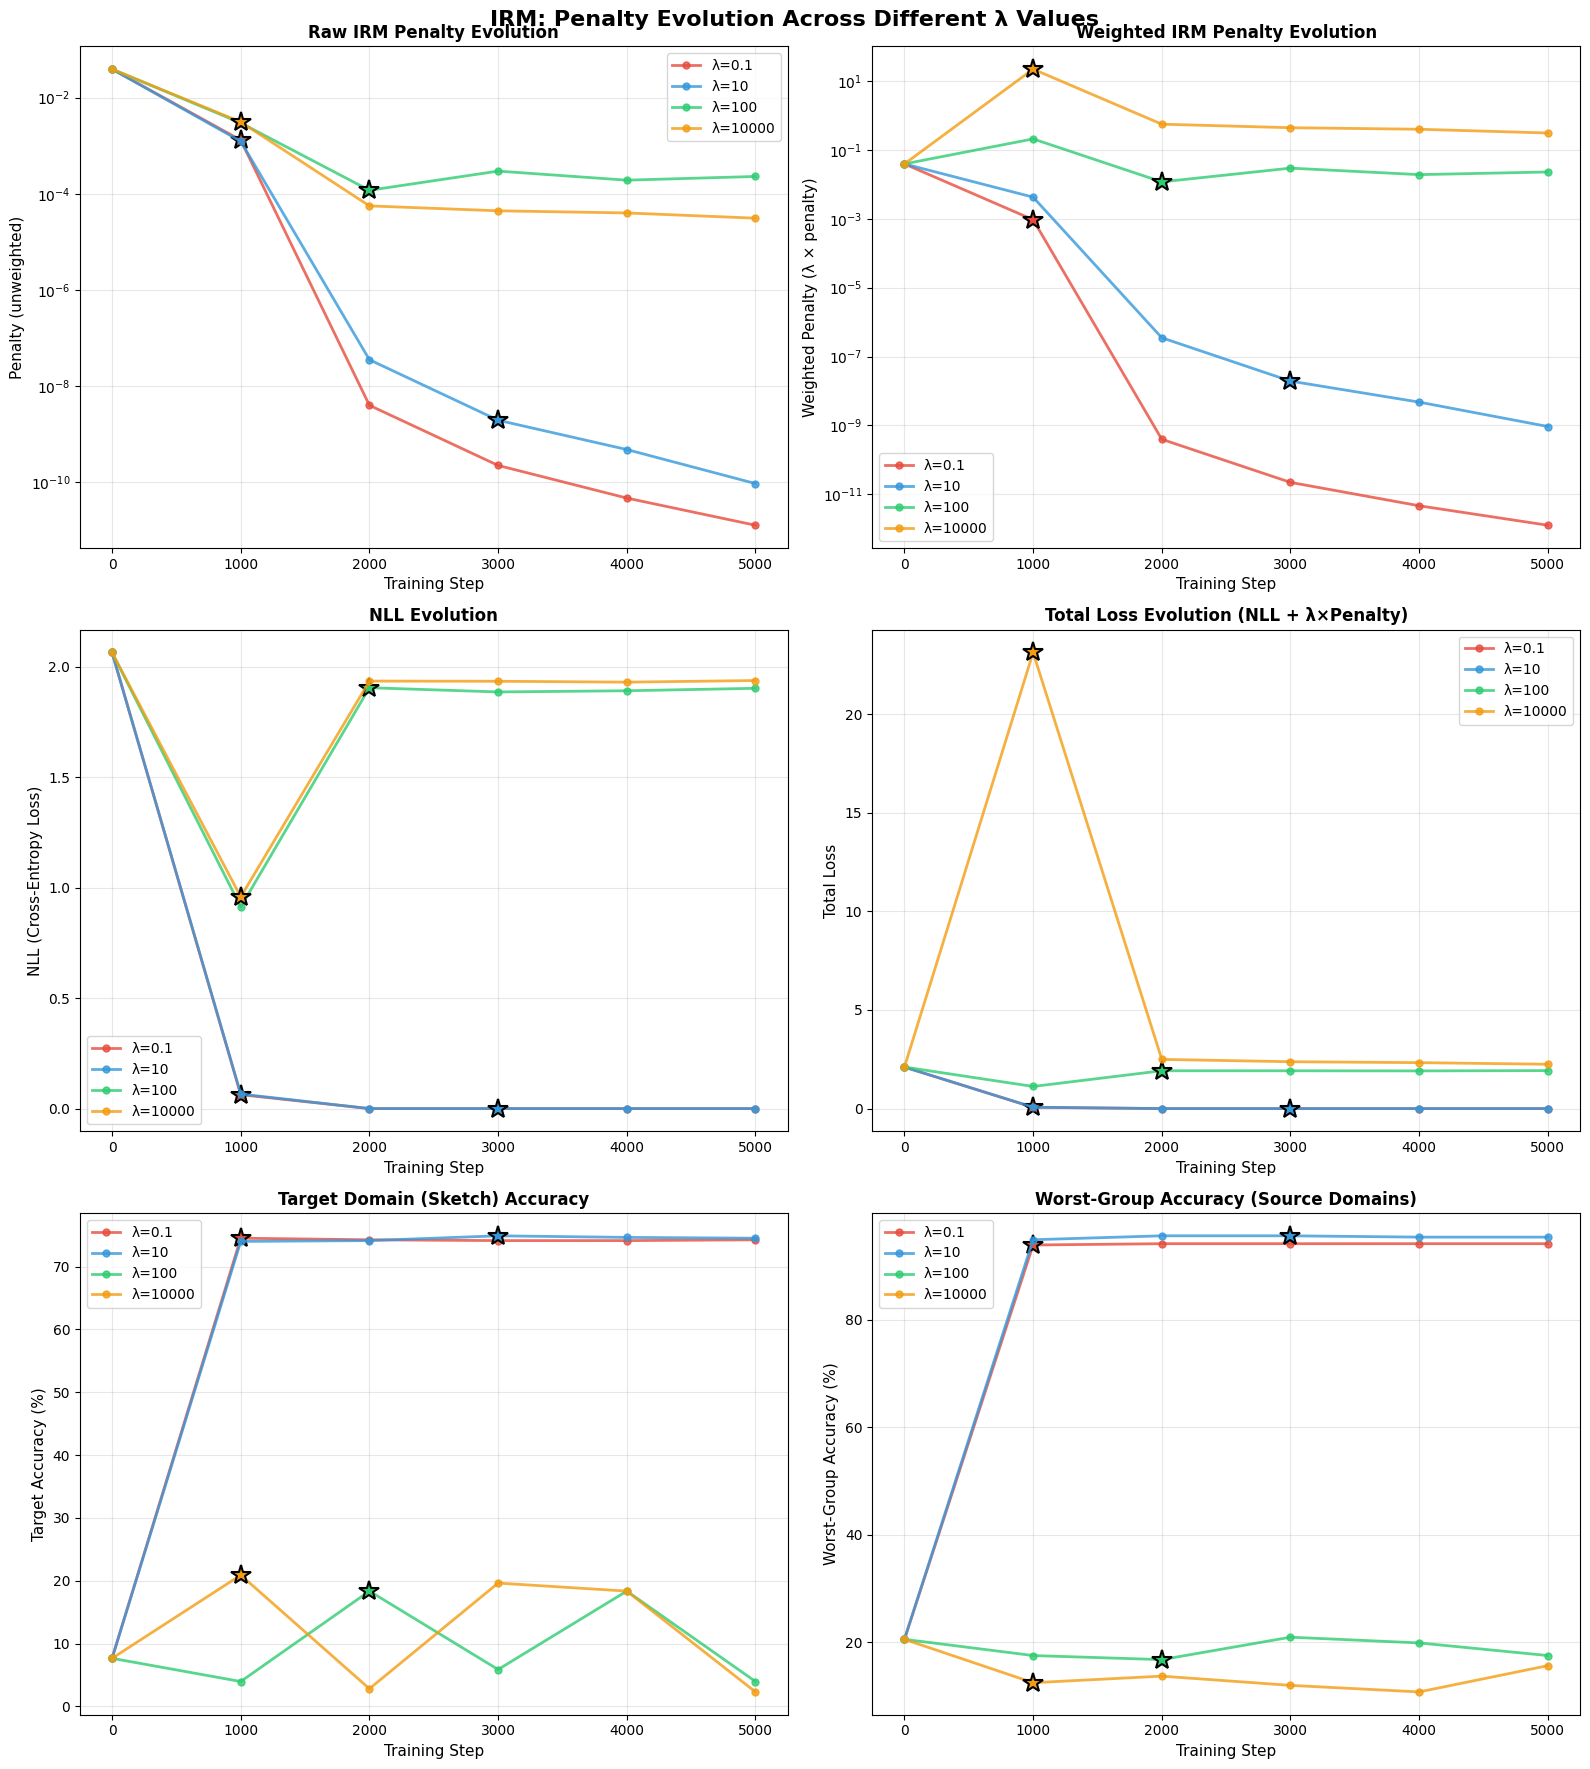


BEST CHECKPOINT STATISTICS
 Lambda  Step Raw Penalty Weighted Penalty    NLL Total Loss Target Acc (%) Worst-Group (%)
  λ=0.1  1000    0.001306         0.000940 0.0629     0.0639          74.52           93.89
   λ=10  3000    0.000000         0.000000 0.0000     0.0000          74.90           95.60
  λ=100  2000    0.000118         0.011795 1.9058     1.9176          18.34           16.77
λ=10000  1000    0.003117        22.170800 0.9586    23.1294          20.89           12.47

PENALTY BEHAVIOR ANALYSIS

λ=0.1:
  λ value: 0.1
  Initial penalty (step 0): 0.039215
  Best penalty (step 1000): 0.001306
  Final penalty: 0.000000
  Penalty reduction (initial→best): 96.67%
  Verification: loss - nll = 0.000940
               λ × penalty = 0.000131

λ=10:
  λ value: 10.0
  Initial penalty (step 0): 0.039215
  Best penalty (step 3000): 0.000000
  Final penalty: 0.000000
  Penalty reduction (initial→best): 100.00%
  Verification: loss - nll = 0.000000
               λ × penalty = 0.000000


In [26]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_irm_results(filepath):
    """Load IRM results from a JSONL file."""
    results = []
    with open(filepath, 'r') as f:
        for line in f:
            data = json.loads(line)
            if 'penalty' in data:
                results.append({
                    'step': data['step'],
                    'epoch': data['epoch'],
                    'loss': data['loss'],
                    'nll': data['nll'],
                    'penalty': data['penalty'],
                    'irm_lambda': data['hparams']['irm_lambda'],
                    'weighted_penalty': data['loss'] - data['nll'],  # This is penalty * lambda
                    'env0_out_acc': data['env0_out_acc'],
                    'env1_out_acc': data['env1_out_acc'],
                    'env2_out_acc': data['env2_out_acc'],
                    'env3_out_acc': data['env3_out_acc']
                })
    return pd.DataFrame(results)

# Load results for different lambda values
irm_paths = {
    'λ=0.1': '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_0.1_penalty/results.jsonl',
    'λ=10': '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10_penalty/results.jsonl',
    'λ=100': '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_100_penalty/results.jsonl',
    'λ=10000': '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10000_penalty/results.jsonl',
}

# Best checkpoint steps for each lambda
best_checkpoints = {
    'λ=0.1': 1000,
    'λ=10': 3000,
    'λ=100': 2000,
    'λ=10000': 1000
}

irm_results = {}
for lambda_name, path in irm_paths.items():
    irm_results[lambda_name] = load_irm_results(path)
    print(f"Loaded {len(irm_results[lambda_name])} checkpoints for IRM {lambda_name}")

print("\n" + "="*80)
print("IRM PENALTY EVOLUTION ANALYSIS")
print("="*80)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('IRM: Penalty Evolution Across Different λ Values', fontsize=16, fontweight='bold')

lambda_names = list(irm_results.keys())
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

# Plot 1: Raw penalty (unweighted) over time
ax = axes[0, 0]
for lambda_name, color in zip(lambda_names, colors):
    df = irm_results[lambda_name]
    ax.plot(df['step'], df['penalty'], 'o-', color=color, 
            linewidth=2, markersize=5, label=lambda_name, alpha=0.8)
    
    # Mark best checkpoint
    best_step = best_checkpoints[lambda_name]
    best_penalty = df[df['step'] == best_step]['penalty'].values
    if len(best_penalty) > 0:
        ax.plot(best_step, best_penalty[0], '*', color=color, 
                markersize=15, markeredgecolor='black', markeredgewidth=1.5)

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Penalty (unweighted)', fontsize=11)
ax.set_title('Raw IRM Penalty Evolution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 2: Weighted penalty (penalty * lambda) over time
ax = axes[0, 1]
for lambda_name, color in zip(lambda_names, colors):
    df = irm_results[lambda_name]
    ax.plot(df['step'], df['weighted_penalty'], 'o-', color=color, 
            linewidth=2, markersize=5, label=lambda_name, alpha=0.8)
    
    # Mark best checkpoint
    best_step = best_checkpoints[lambda_name]
    best_weighted = df[df['step'] == best_step]['weighted_penalty'].values
    if len(best_weighted) > 0:
        ax.plot(best_step, best_weighted[0], '*', color=color, 
                markersize=15, markeredgecolor='black', markeredgewidth=1.5)

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Weighted Penalty (λ × penalty)', fontsize=11)
ax.set_title('Weighted IRM Penalty Evolution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 3: NLL (cross-entropy loss) over time
ax = axes[1, 0]
for lambda_name, color in zip(lambda_names, colors):
    df = irm_results[lambda_name]
    ax.plot(df['step'], df['nll'], 'o-', color=color, 
            linewidth=2, markersize=5, label=lambda_name, alpha=0.8)
    
    # Mark best checkpoint
    best_step = best_checkpoints[lambda_name]
    best_nll = df[df['step'] == best_step]['nll'].values
    if len(best_nll) > 0:
        ax.plot(best_step, best_nll[0], '*', color=color, 
                markersize=15, markeredgecolor='black', markeredgewidth=1.5)

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('NLL (Cross-Entropy Loss)', fontsize=11)
ax.set_title('NLL Evolution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Total loss (NLL + weighted penalty) over time
ax = axes[1, 1]
for lambda_name, color in zip(lambda_names, colors):
    df = irm_results[lambda_name]
    ax.plot(df['step'], df['loss'], 'o-', color=color, 
            linewidth=2, markersize=5, label=lambda_name, alpha=0.8)
    
    # Mark best checkpoint
    best_step = best_checkpoints[lambda_name]
    best_loss = df[df['step'] == best_step]['loss'].values
    if len(best_loss) > 0:
        ax.plot(best_step, best_loss[0], '*', color=color, 
                markersize=15, markeredgecolor='black', markeredgewidth=1.5)

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Total Loss', fontsize=11)
ax.set_title('Total Loss Evolution (NLL + λ×Penalty)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 5: Target domain accuracy over time
ax = axes[2, 0]
for lambda_name, color in zip(lambda_names, colors):
    df = irm_results[lambda_name]
    ax.plot(df['step'], df['env3_out_acc'] * 100, 'o-', color=color, 
            linewidth=2, markersize=5, label=lambda_name, alpha=0.8)
    
    # Mark best checkpoint
    best_step = best_checkpoints[lambda_name]
    best_acc = df[df['step'] == best_step]['env3_out_acc'].values
    if len(best_acc) > 0:
        ax.plot(best_step, best_acc[0] * 100, '*', color=color, 
                markersize=15, markeredgecolor='black', markeredgewidth=1.5)

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Target Accuracy (%)', fontsize=11)
ax.set_title('Target Domain (Sketch) Accuracy', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 6: Worst-group accuracy over time
ax = axes[2, 1]
for lambda_name, color in zip(lambda_names, colors):
    df = irm_results[lambda_name]
    df['worst_acc'] = df[['env0_out_acc', 'env1_out_acc', 'env2_out_acc']].min(axis=1)
    ax.plot(df['step'], df['worst_acc'] * 100, 'o-', color=color, 
            linewidth=2, markersize=5, label=lambda_name, alpha=0.8)
    
    # Mark best checkpoint
    best_step = best_checkpoints[lambda_name]
    best_worst = df[df['step'] == best_step]['worst_acc'].values
    if len(best_worst) > 0:
        ax.plot(best_step, best_worst[0] * 100, '*', color=color, 
                markersize=15, markeredgecolor='black', markeredgewidth=1.5)

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Worst-Group Accuracy (%)', fontsize=11)
ax.set_title('Worst-Group Accuracy (Source Domains)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics at best checkpoints
print("\n" + "="*80)
print("BEST CHECKPOINT STATISTICS")
print("="*80)

summary_data = []
for lambda_name in lambda_names:
    df = irm_results[lambda_name]
    best_step = best_checkpoints[lambda_name]
    best_row = df[df['step'] == best_step].iloc[0]
    
    summary_data.append({
        'Lambda': lambda_name,
        'Step': int(best_row['step']),
        'Raw Penalty': f"{best_row['penalty']:.6f}",
        'Weighted Penalty': f"{best_row['weighted_penalty']:.6f}",
        'NLL': f"{best_row['nll']:.4f}",
        'Total Loss': f"{best_row['loss']:.4f}",
        'Target Acc (%)': f"{best_row['env3_out_acc'] * 100:.2f}",
        'Worst-Group (%)': f"{min(best_row['env0_out_acc'], best_row['env1_out_acc'], best_row['env2_out_acc']) * 100:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Detailed analysis of penalty behavior
print("\n" + "="*80)
print("PENALTY BEHAVIOR ANALYSIS")
print("="*80)

for lambda_name in lambda_names:
    df = irm_results[lambda_name]
    best_step = best_checkpoints[lambda_name]
    
    # Initial penalty (step 0)
    initial_penalty = df.iloc[0]['penalty']
    
    # Penalty at best checkpoint
    best_penalty = df[df['step'] == best_step]['penalty'].values[0]
    
    # Final penalty
    final_penalty = df.iloc[-1]['penalty']
    
    # Penalty reduction
    penalty_reduction = (initial_penalty - best_penalty) / initial_penalty * 100
    
    print(f"\n{lambda_name}:")
    print(f"  λ value: {df.iloc[0]['irm_lambda']}")
    print(f"  Initial penalty (step 0): {initial_penalty:.6f}")
    print(f"  Best penalty (step {best_step}): {best_penalty:.6f}")
    print(f"  Final penalty: {final_penalty:.6f}")
    print(f"  Penalty reduction (initial→best): {penalty_reduction:.2f}%")
    print(f"  Verification: loss - nll = {df[df['step'] == best_step]['loss'].values[0] - df[df['step'] == best_step]['nll'].values[0]:.6f}")
    print(f"               λ × penalty = {df[df['step'] == best_step]['irm_lambda'].values[0] * best_penalty:.6f}")

# Correlation analysis: penalty vs accuracy
print("\n" + "="*80)
print("PENALTY-ACCURACY CORRELATION")
print("="*80)

for lambda_name in lambda_names:
    df = irm_results[lambda_name]
    
    # Correlation between penalty and target accuracy
    corr_target = np.corrcoef(df['penalty'], df['env3_out_acc'])[0, 1]
    
    # Correlation between penalty and worst-group accuracy
    df['worst_acc'] = df[['env0_out_acc', 'env1_out_acc', 'env2_out_acc']].min(axis=1)
    corr_worst = np.corrcoef(df['penalty'], df['worst_acc'])[0, 1]
    
    print(f"\n{lambda_name}:")
    print(f"  Penalty ↔ Target accuracy:     {corr_target:+.3f}")
    print(f"  Penalty ↔ Worst-group accuracy: {corr_worst:+.3f}")
    
    if corr_target < 0 and corr_worst < 0:
        print("  ✓ Negative correlation: Lower penalty → better generalization!")